In [1]:
# !pip install -q optuna lightgbm seaborn statsmodels

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Setting float display format
import pandas as pd
pd.options.display.float_format = '{:.3f}'.format

# Core imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import datetime

# Plot style
sns.set(style="darkgrid")
SEED = 42
np.random.seed(SEED)

In [3]:
df1 = pd.read_csv('./dataset_1.csv', parse_dates=['date'], index_col='date')
df2 = pd.read_csv('./dataset_2.csv', parse_dates=['date'], index_col='date')

In [4]:
df1.head()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,v1,v2
date,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,60.000,30.000,19.890,47.597,19.200,44.790,19.790,44.730,19.000,45.567,...,17.033,45.530,6.600,733.500,92.000,7.000,63.000,5.300,13.275,13.275
2016-01-11 17:10:00,60.000,30.000,19.890,46.693,19.200,44.722,19.790,44.790,19.000,45.992,...,NaN,45.560,6.483,733.600,92.000,6.667,NaN,5.200,18.606,18.606
2016-01-11 17:20:00,50.000,30.000,19.890,46.300,19.200,44.627,19.790,44.933,18.927,45.890,...,17.000,45.500,6.367,NaN,92.000,6.333,55.333,5.100,28.643,28.643
2016-01-11 17:30:00,50.000,40.000,19.890,46.067,19.200,44.590,19.790,45.000,18.890,45.723,...,17.000,45.400,6.250,733.800,NaN,6.000,51.500,5.000,45.410,45.410
2016-01-11 17:40:00,60.000,40.000,19.890,46.333,19.200,44.530,19.790,45.000,18.890,45.530,...,17.000,45.400,6.133,733.900,NaN,5.667,47.667,4.900,10.084,10.084


## Step 1:Data Preprocessing

In [5]:
df1.describe()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,v1,v2
count,16459.000,16360.000,14314.000,14308.000,14180.000,14522.000,14273.000,14469.000,15017.000,14388.000,...,14622.000,14423.000,16330.000,15129.000,15961.000,15346.000,15142.000,15612.000,17610.000,17610.000
mean,96.233,3.979,21.415,40.251,20.081,40.420,21.942,39.464,20.476,39.181,...,19.048,41.647,6.722,755.475,80.178,4.125,38.524,3.167,24.947,24.947
std,102.028,8.079,1.490,3.762,2.017,3.878,1.792,3.231,1.893,4.241,...,1.776,4.114,5.020,7.737,14.717,2.488,11.957,3.873,14.508,14.508
min,10.000,0.000,16.790,27.023,16.100,20.597,17.200,30.663,15.100,27.660,...,14.890,29.167,-5.000,729.300,24.000,0.000,1.000,-6.600,0.005,0.005
25%,50.000,0.000,20.600,37.560,18.730,38.000,20.600,37.090,19.290,35.879,...,17.890,38.590,3.233,750.650,71.000,2.000,29.000,0.600,12.470,12.470
50%,60.000,0.000,21.390,39.627,19.760,40.590,21.890,38.730,20.390,38.500,...,18.890,41.000,6.250,755.817,84.000,3.833,40.000,2.950,24.791,24.791
75%,100.000,0.000,22.230,43.030,21.100,43.230,23.000,42.000,21.533,42.200,...,20.323,44.457,9.650,761.650,91.667,5.667,40.000,5.600,37.579,37.579
max,1080.000,70.000,25.700,63.360,29.857,56.027,27.600,50.163,26.200,51.090,...,24.200,53.327,26.100,772.300,100.000,14.000,66.000,15.500,49.997,49.997


In [6]:
df2.describe()

,index,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,v1,v2
count,2125.000,2113.000,1798.000,1823.000,1807.000,1851.000,1830.000,1853.000,1924.000,1841.000,...,1868.000,1844.000,1987.000,1836.000,1937.000,1873.000,1833.000,1907.000,2125.000,2125.000
mean,18672.000,2.191,23.969,42.532,23.100,41.485,25.321,39.372,23.890,40.700,...,22.888,42.657,13.125,755.850,76.321,3.299,36.396,8.627,25.332,25.332
std,613.579,6.184,0.773,4.689,1.765,5.193,1.155,3.371,0.670,4.302,...,0.516,4.572,4.111,3.961,15.953,1.879,10.421,3.453,14.403,14.403
min,17610.000,0.000,22.700,31.290,20.200,29.319,23.000,28.767,22.500,28.716,...,21.518,29.850,3.600,745.500,44.000,0.000,1.000,0.100,0.030,0.030
25%,18141.000,0.000,23.390,39.572,21.790,37.590,24.390,37.526,23.390,38.200,...,22.600,39.652,10.042,753.467,63.000,2.000,28.667,6.858,12.715,12.715
50%,18672.000,0.000,23.927,41.530,22.890,41.400,24.914,39.090,23.790,40.223,...,22.790,43.127,12.900,756.658,79.667,3.000,38.167,8.533,25.686,25.686
75%,19203.000,0.000,24.500,45.900,24.200,44.780,26.056,41.955,24.230,44.067,...,23.100,46.200,15.883,758.487,90.500,4.500,40.000,11.200,37.693,37.693
max,19734.000,30.000,26.260,54.667,29.260,54.090,29.200,47.560,25.890,50.760,...,24.500,51.536,23.100,762.100,100.000,10.000,65.000,15.100,49.982,49.982


In [7]:
print("Dataset 1")
print("Duplicates:", df1.index.duplicated().sum())
print("Missing rows due to gaps:", df1.isna().any(axis=1).sum())
print(df1.isnull().sum())

print("\nDataset 2")
print("Missing rows due to gaps:", df2.isna().any(axis=1).sum())
print(df2.isnull().sum())

Dataset 1
Duplicates: 0
Missing rows due to gaps: 13495
Appliances     1151
lights         1250
T1             3296
RH_1           3302
T2             3430
RH_2           3088
T3             3337
RH_3           3141
T4             2593
RH_4           3222
T5             2897
RH_5           2874
T6             3529
RH_6           2832
T7             3434
RH_7           3954
T8             3774
RH_8           2759
T9             2988
RH_9           3187
T_out          1280
Press_mm_hg    2481
RH_out         1649
Windspeed      2264
Visibility     2468
Tdewpoint      1998
v1                0
v2                0
dtype: int64

Dataset 2
Missing rows due to gaps: 1604
index            0
lights          12
T1             327
RH_1           302
T2             318
RH_2           274
T3             295
RH_3           272
T4             201
RH_4           284
T5             254
RH_5           238
T6             320
RH_6           232
T7             308
RH_7           364
T8             343
RH_8  

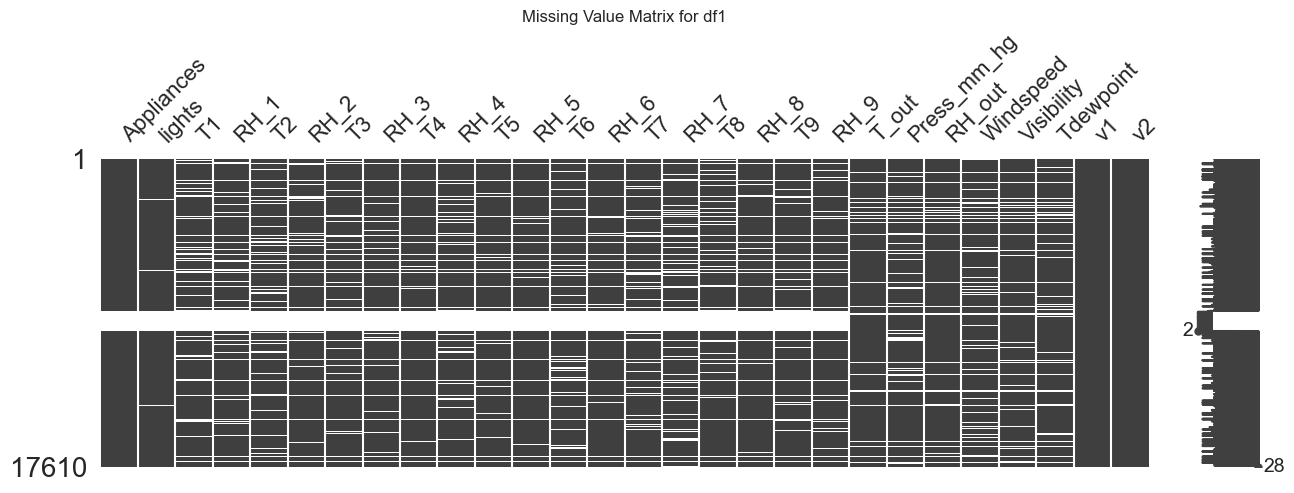

In [8]:
import missingno as msno

msno.matrix(df1, figsize=(15, 4))
plt.title("Missing Value Matrix for df1")
plt.tight_layout()
plt.show()


*Data Quality Insights and Cleaning Strategy*

- Data is in consistent 10-minute intervals from Jan to May 2016.
- March 12–19 has a full outage of environmental sensors; only `Appliances` and `lights` are recorded.
- Short gaps (1–6 steps) exist in temperature and humidity columns.

*Cleaning and Imputation Plan*

1. Mark March 12–19 as fully missing to prevent inaccurate lags (will later drop only the rows where any feature required for modeling is NaN.).
2. Interpolate short gaps (≤ 1 hour) using linear interpolation.
3. Do not impute longer (more than 1 hour if it exists) outages or rows missing all sensor data for now.


In [9]:
df1_interp = df1.copy()
df1_interp = df1_interp.interpolate(limit=6, limit_direction='forward')


Note: Using the forward method for interpolation limits data leakage risk, as it only fills missing values using past data, not future observations.

In [10]:
df1_interp.loc["2016-03-12":"2016-03-19"] = np.nan


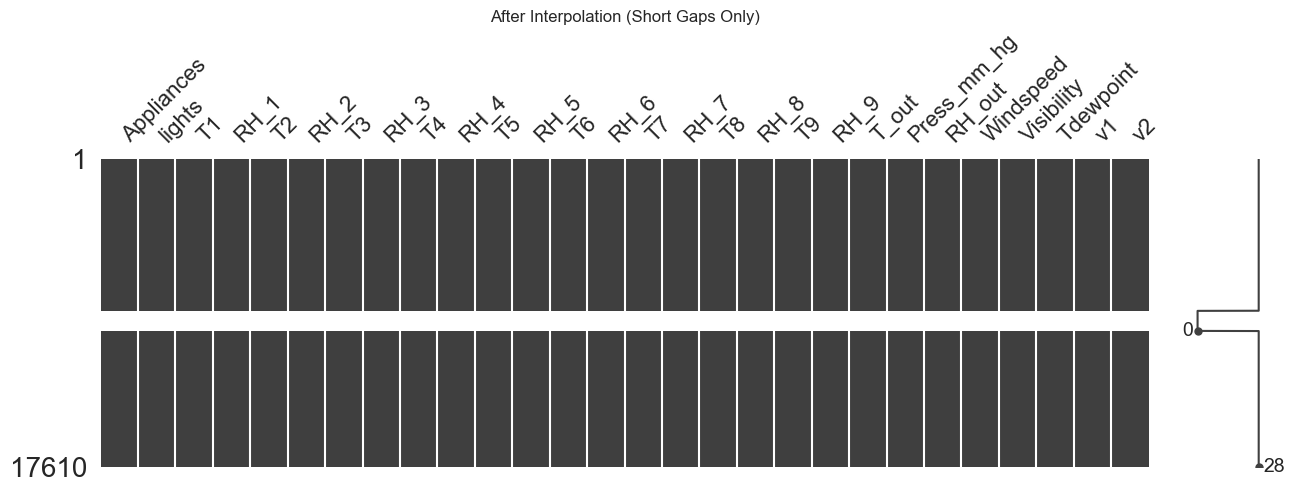

In [11]:
msno.matrix(df1_interp, figsize=(15, 4))
plt.title("After Interpolation (Short Gaps Only)")
plt.tight_layout()
plt.show()


After applying linear interpolation with a 1-hour limit, all short gaps across sensor columns were filled, while longer outages (like March 12–19) kept untouched (until feature engineering) to ensure lag/moving averages are accurately calculated for the week after that.

## Step2: EDA

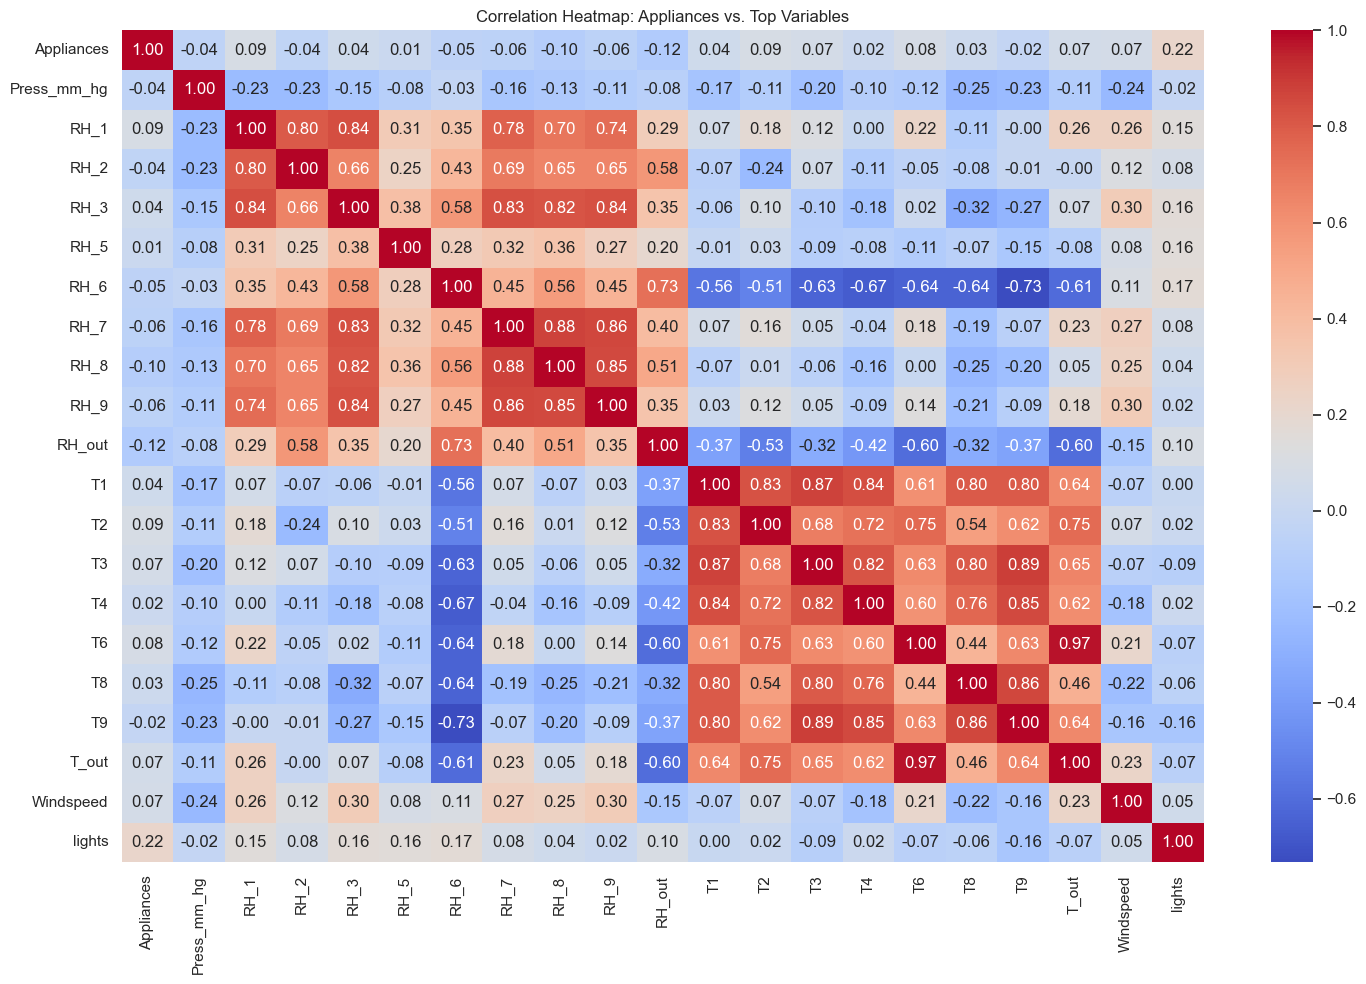

In [12]:
sns.set(style="darkgrid")
plt.rcParams["figure.figsize"] = (20, 12)

# Correlation with top sensor features
corr = df1_interp.corr()['Appliances'].drop('Appliances')
top_corr = corr.abs().sort_values(ascending=False).head(20).index
top_features = top_corr.union(['Appliances'])

plt.figure(figsize=(15, 10))
sns.heatmap(df1_interp[top_features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap: Appliances vs. Top Variables")
plt.tight_layout()
plt.show()

*Correlation Insights*

- Most temperature and humidity variables (e.g., `T2`, `T_out`, `RH_8`) show **low correlation** with `Appliances`, indicating that nonlinear interactions or time-based patterns may be more informative.
- Strong multicollinearity is observed among environmental variables, especially:
  - `RH_7`, `RH_8`, `RH_1` (humidity across rooms)  
  - `T2`, `T6`, `T_out` (temperatures, especially indoor-outdoor)
- These relationships suggest that tree-based models (e.g., LightGBM) may be better suited, as they handle multicollinearity and interaction effects without explicit feature selection.

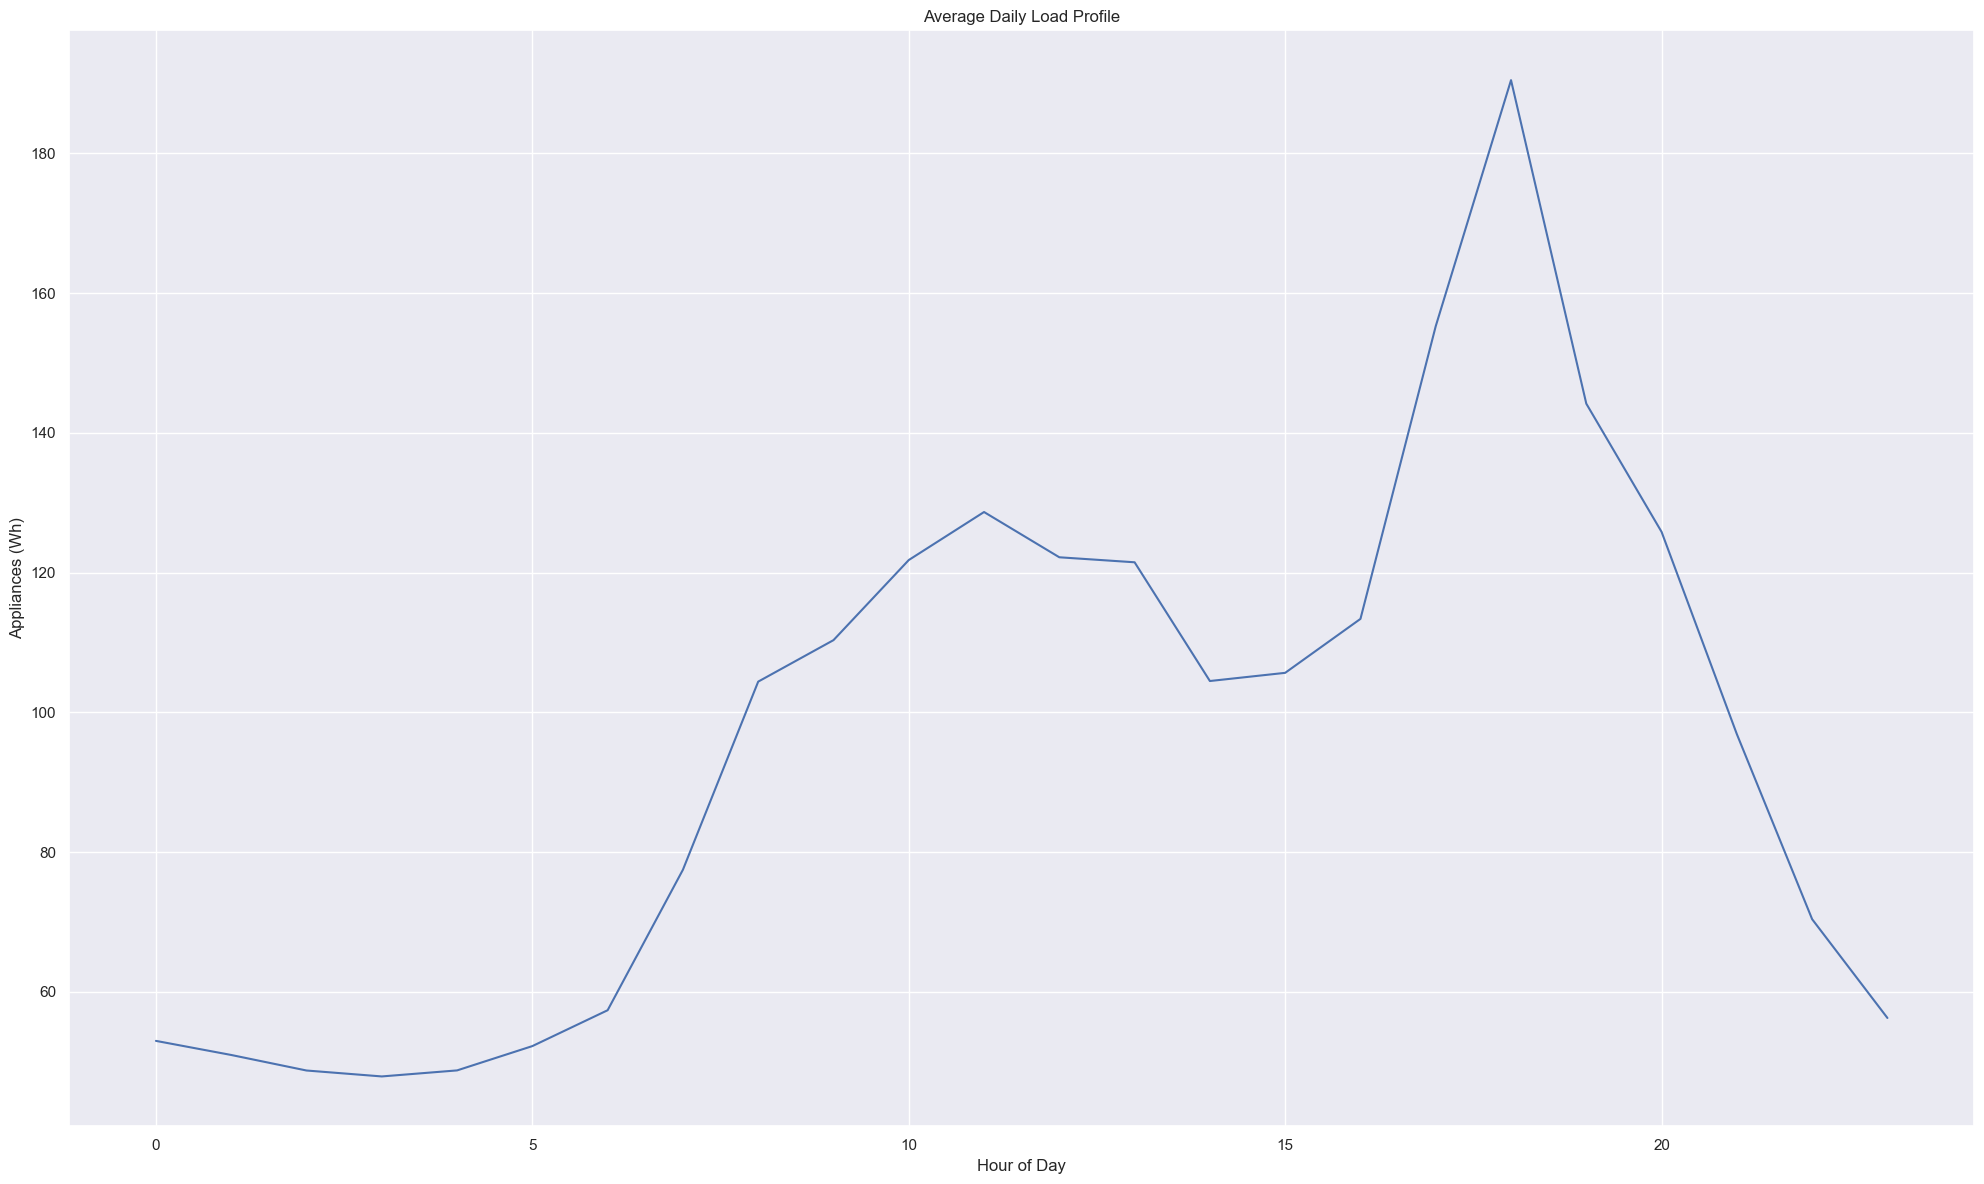

In [13]:
df1_interp['hour'] = df1_interp.index.hour
daily_profile = df1_interp.groupby('hour')['Appliances'].mean()

plt.figure()
daily_profile.plot()
plt.title("Average Daily Load Profile")
plt.xlabel("Hour of Day")
plt.ylabel("Appliances (Wh)")
plt.tight_layout()
plt.show()


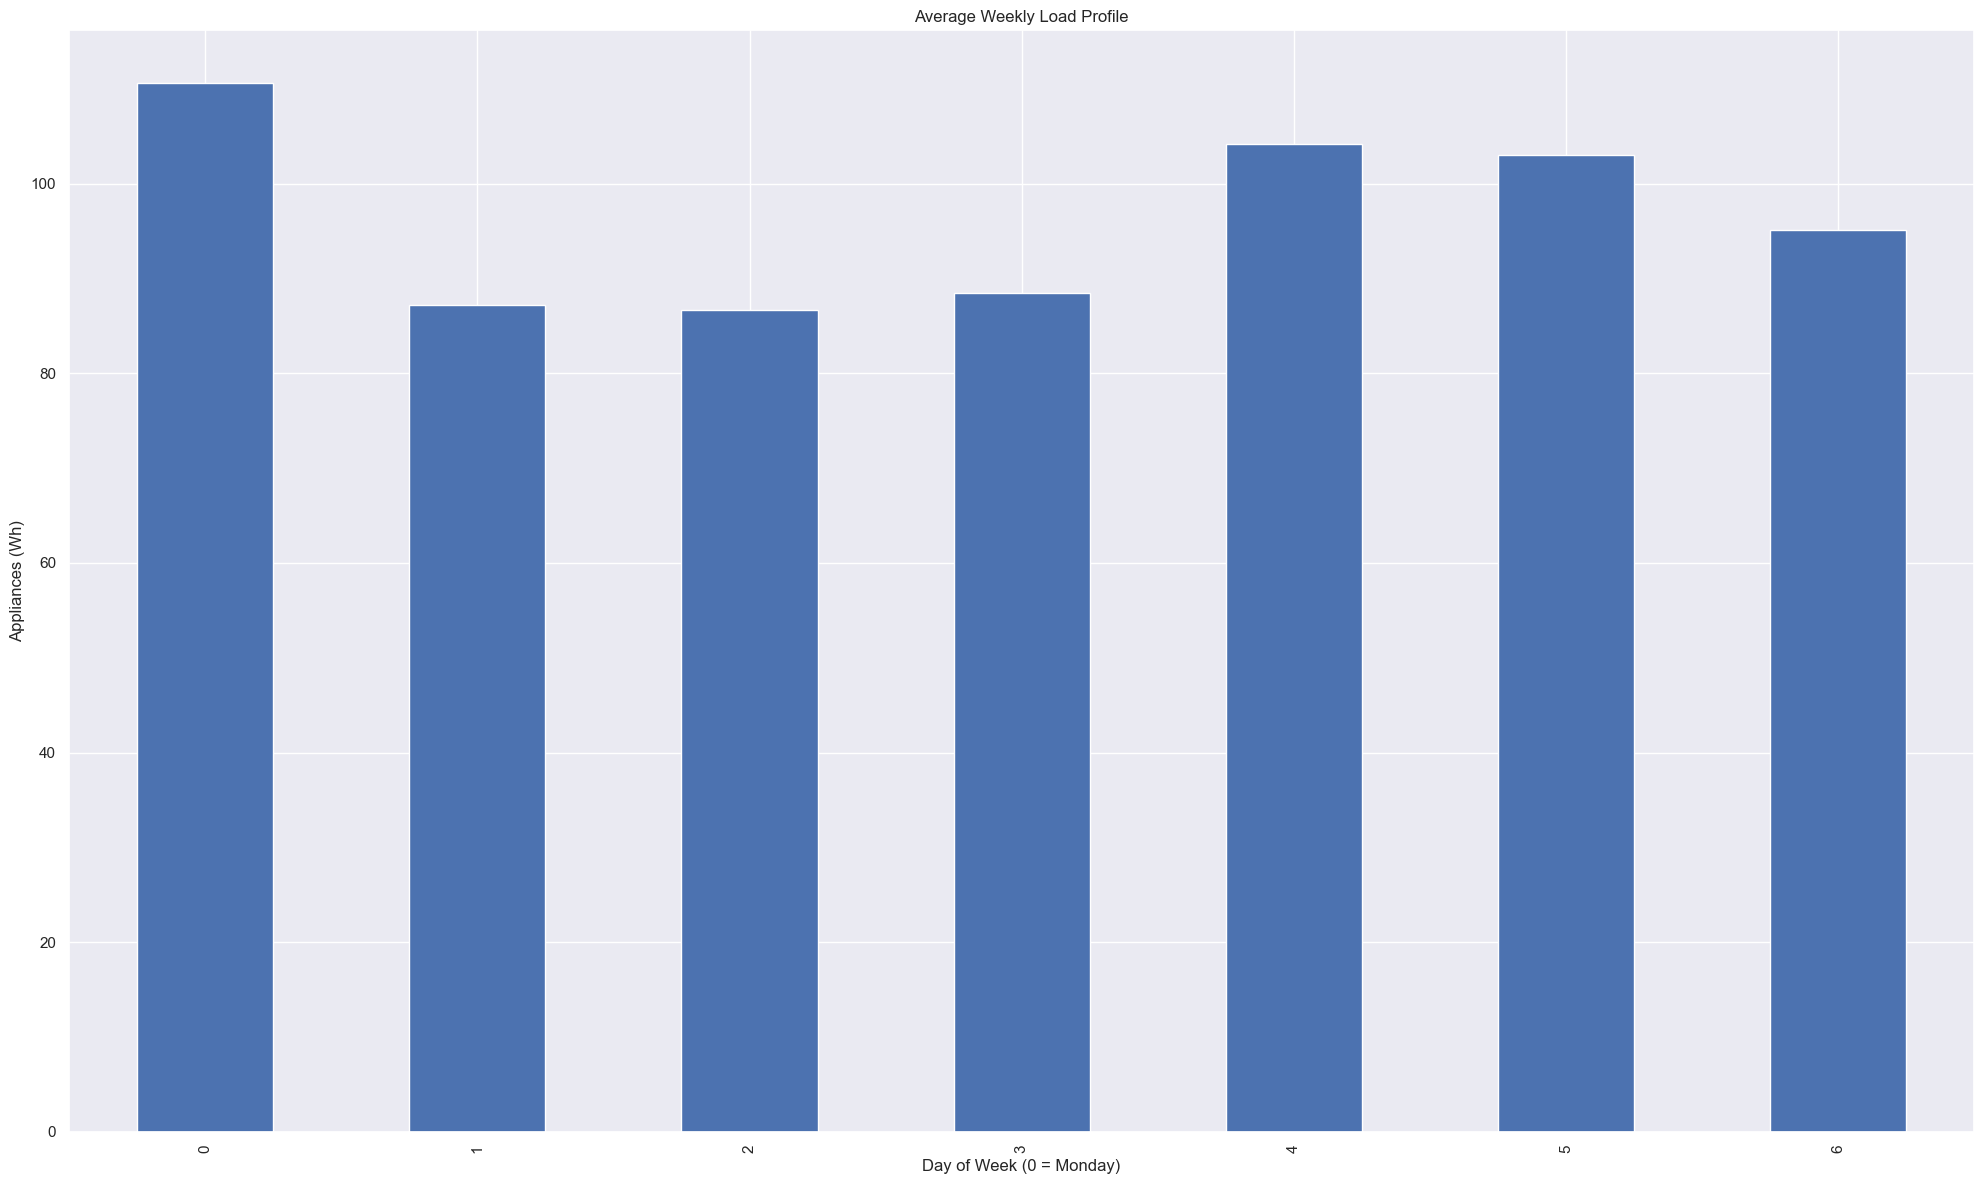

In [14]:

# Weekly profile
df1_interp['dayofweek'] = df1_interp.index.dayofweek
weekly_profile = df1_interp.groupby('dayofweek')['Appliances'].mean()

plt.figure()
weekly_profile.plot(kind='bar')
plt.title("Average Weekly Load Profile")
plt.xlabel("Day of Week (0 = Monday)")
plt.ylabel("Appliances (Wh)")
plt.tight_layout()
plt.show()


- **Daily Profile**: Energy usage peaks around 17:00–18:00, with a gradual rise starting at 06:00. This reflects typical household routines and justifies time-based features like `hour`, `hour_sin/cos`, and a binary `is_peak_hour` feature.
- **Weekly Profile**: Usage is highest on Mondays, with steady consumption throughout the rest of the week. A `day_of_week` and `weekend` flag to be created.
  

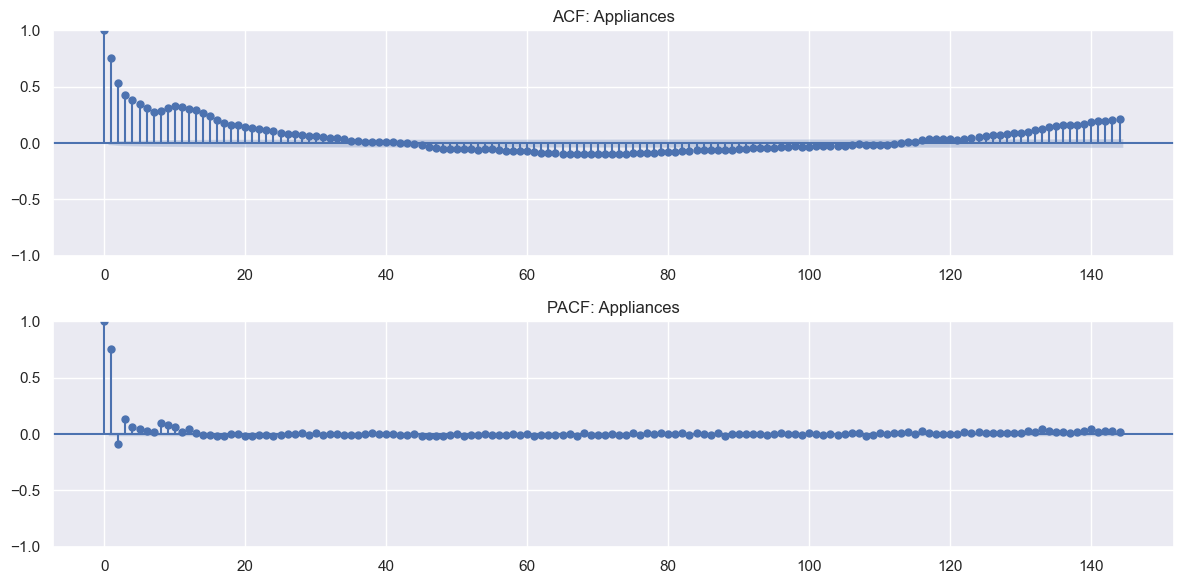

In [15]:

# ACF and PACF
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
plot_acf(df1_interp['Appliances'].dropna(), lags=144, ax=ax[0])
plot_pacf(df1_interp['Appliances'].dropna(), lags=144, ax=ax[1])
ax[0].set_title("ACF: Appliances")
ax[1].set_title("PACF: Appliances")
plt.tight_layout()
plt.show()


The ACF and PACF plots show strong short-term autocorrelation and clear daily seasonality, indicating that recent lags and same-time-yesterday values are predictive of appliance energy usage.

Next steps:

- Include lag features at 1-3, 6, 12, and 144 steps (10 min-30min, 1h, 2h, 24h).
- Use rolling averages (1h, 3h) to smooth short-term fluctuations.
- Avoid including distant lags beyond those, as PACF shows low marginal contribution.

### Checking validity of outliers and distributions of variables

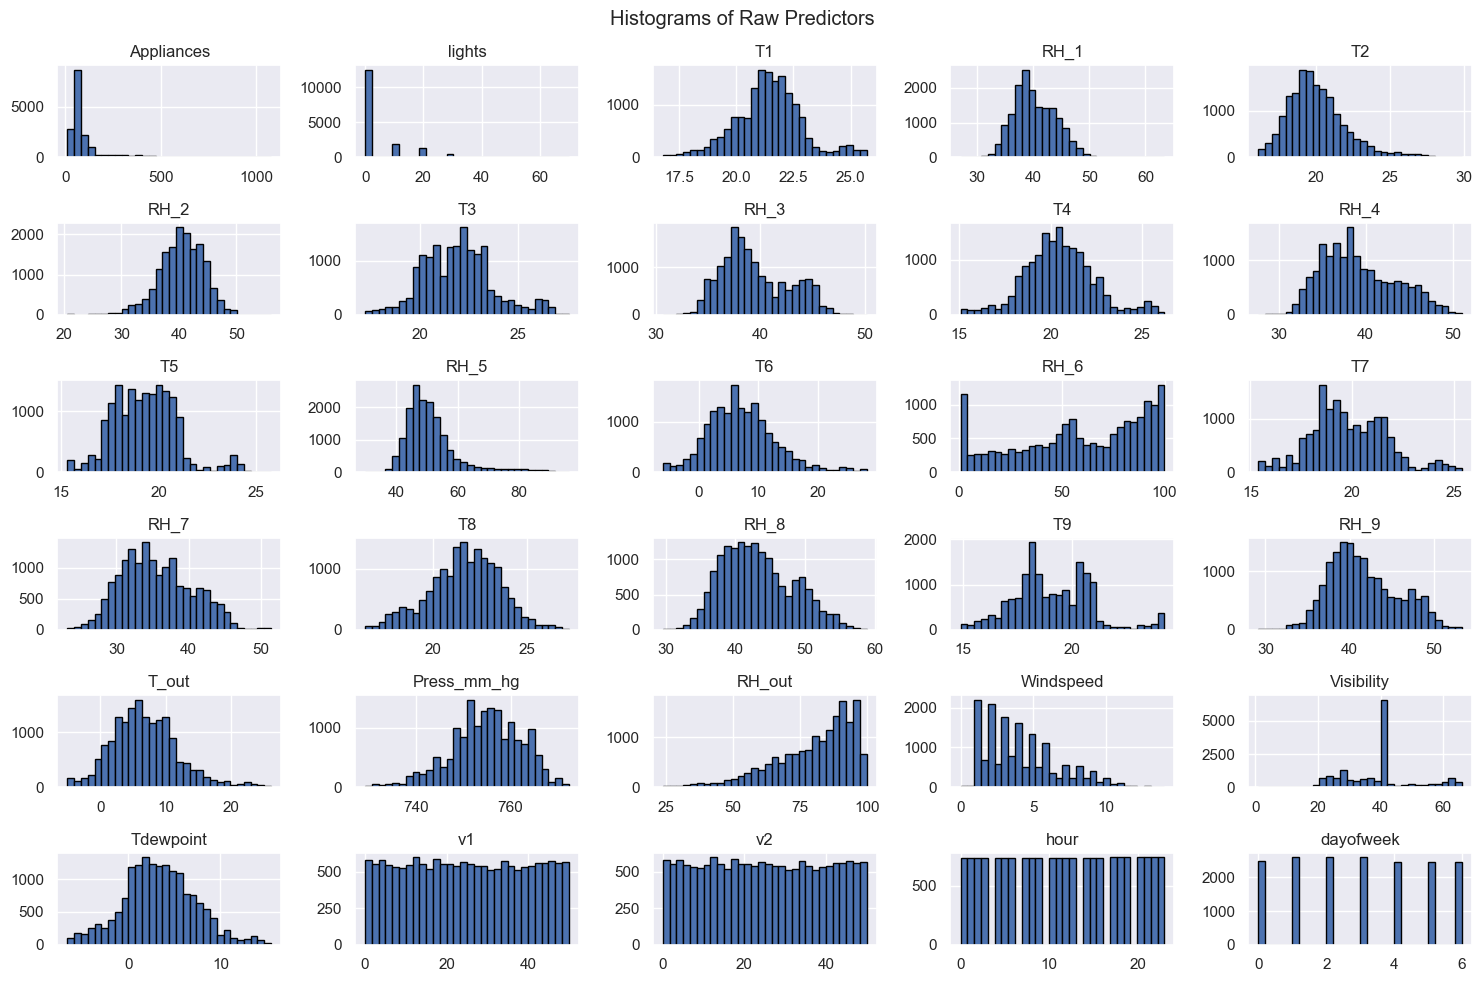

In [16]:
df1_interp.hist(bins=30, figsize=(15, 10), edgecolor='black')
plt.suptitle('Histograms of Raw Predictors')
plt.tight_layout()
plt.show()

### Distribution Insights from Raw Predictors

Most features are reasonably distributed, though a few (e.g., `Appliances`, `lights`, `RH_out`, `Windspeed`, `Visibility`) show right-skewed or long-tailed patterns. Temperature and humidity variables are largely normally distributed, and time-based features are evenly sampled. Given the robustness of tree-based models like LightGBM, no transformation was applied for now.


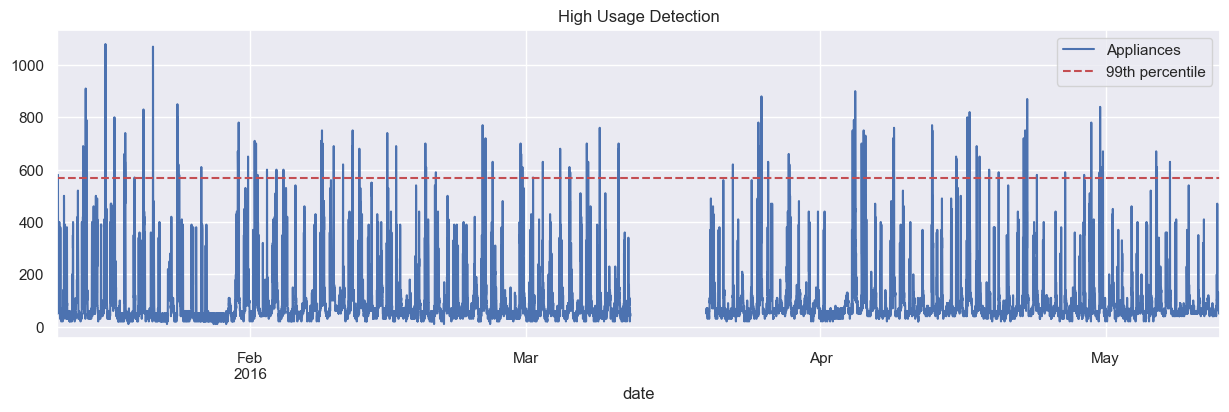

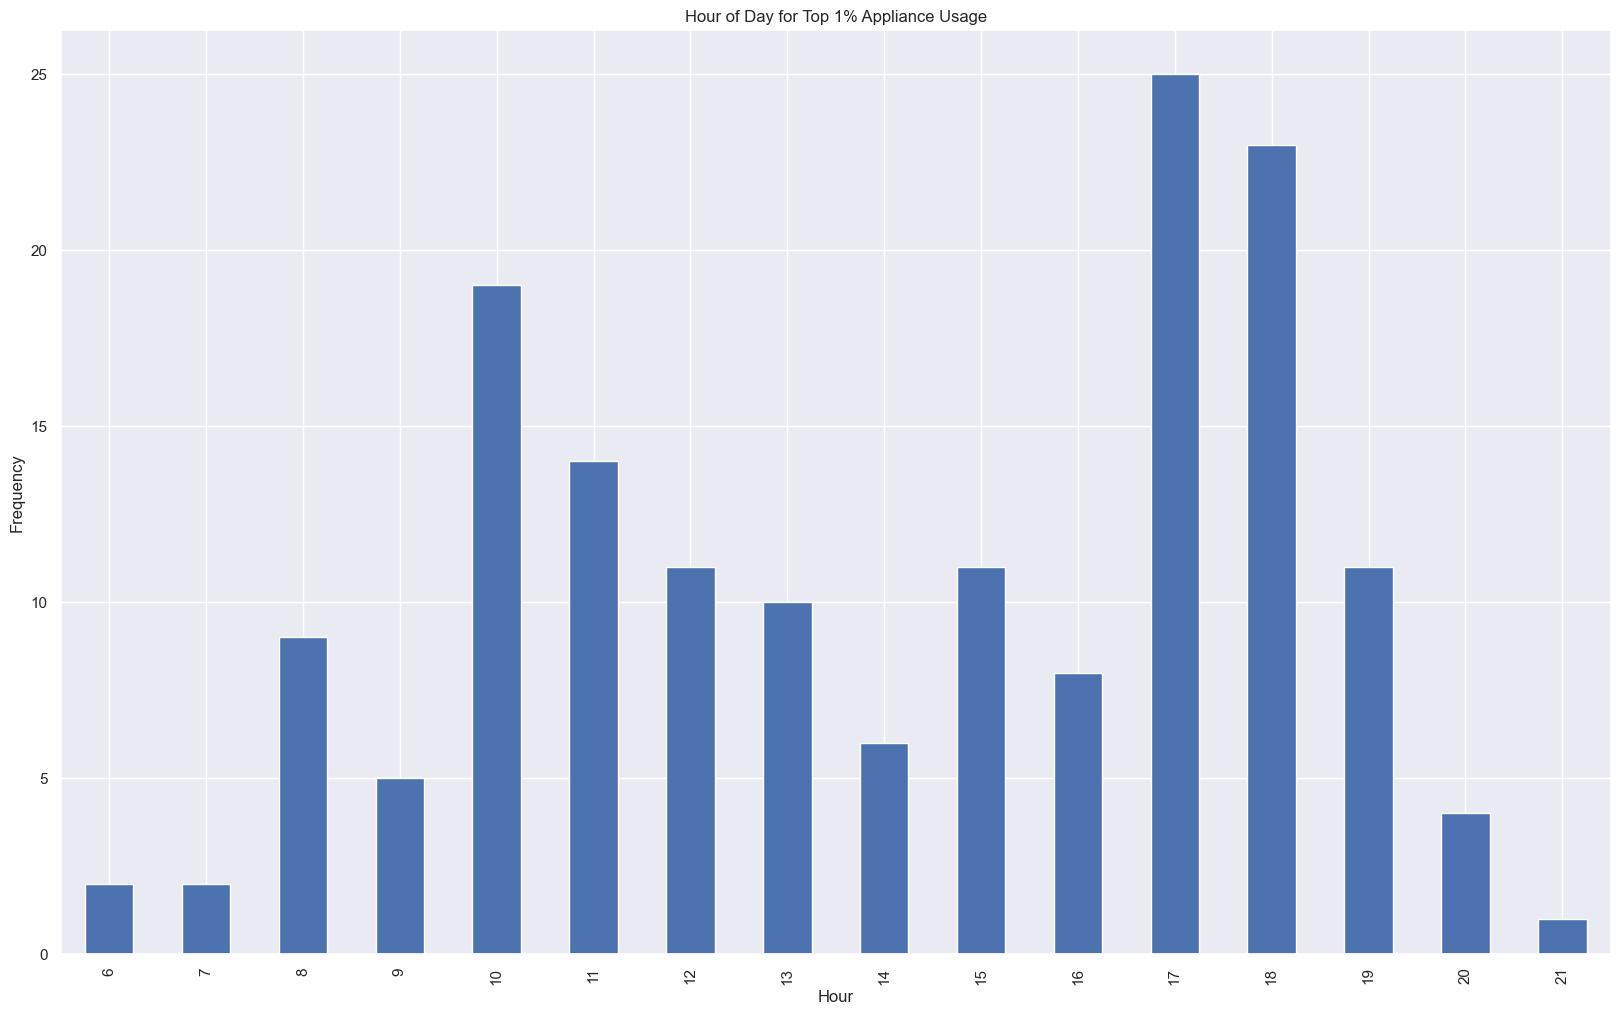

In [17]:
# Quantify upper tail
df1_interp['Appliances'].describe(percentiles=[0.95, 0.99])

# Plot time series of Appliances with threshold line
df1_interp['Appliances'].plot(figsize=(15,4))
plt.axhline(df1_interp['Appliances'].quantile(0.99), color='r', linestyle='--', label='99th percentile')
plt.legend()
plt.title('High Usage Detection')
plt.show()

# When do they occur?
df1_interp['hour'] = df1_interp.index.hour
high_usage = df1_interp[df1_interp['Appliances'] > df1_interp['Appliances'].quantile(0.99)]
high_usage['hour'].value_counts().sort_index().plot(kind='bar')
plt.title('Hour of Day for Top 1% Appliance Usage')
plt.xlabel('Hour')
plt.ylabel('Frequency')
plt.show()


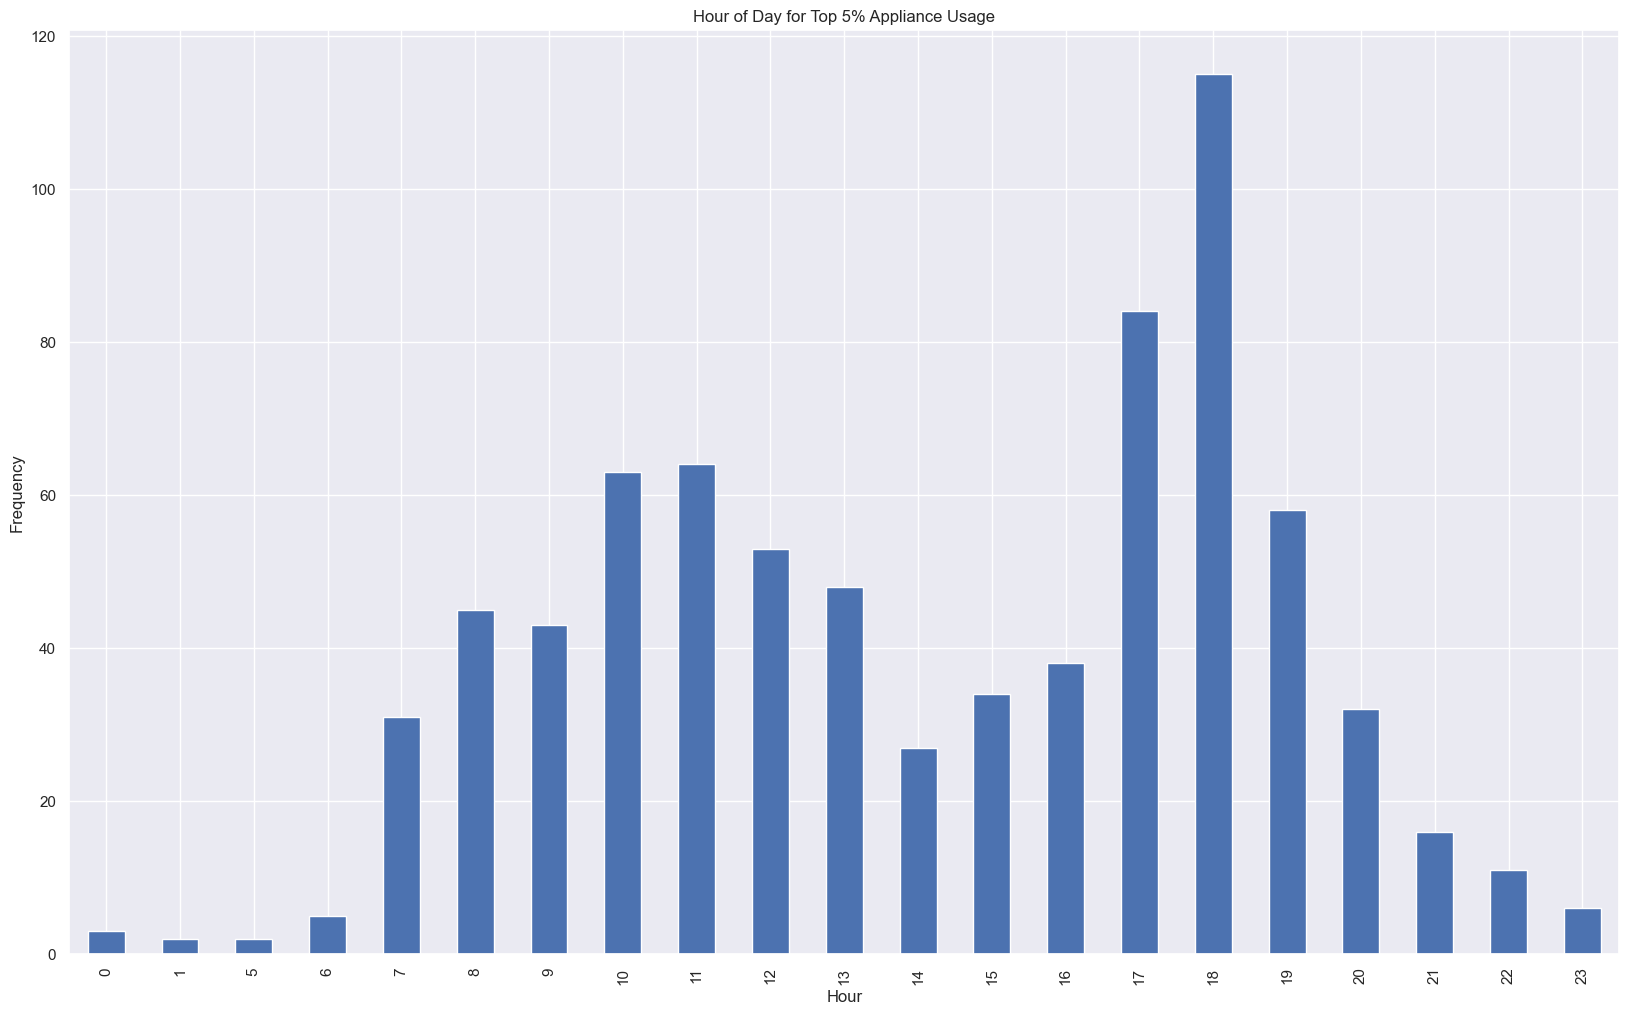

In [18]:
# When do they occur?
df1_interp['hour'] = df1_interp.index.hour
high_usage = df1_interp[df1_interp['Appliances'] > df1_interp['Appliances'].quantile(0.95)]
high_usage['hour'].value_counts().sort_index().plot(kind='bar')
plt.title('Hour of Day for Top 5% Appliance Usage')
plt.xlabel('Hour')
plt.ylabel('Frequency')
plt.show()

**Outlier Insight**: High Appliances usage values, though extreme, occur predominantly during active hours—especially around 17:00–18:00—indicating valid demand patterns rather than outliers requiring removal.

## Step 3: Feature Engineering

Assumptions and Observations:
- Since `dataset_2` provides explanatory variables for the forecast period, I assume they are fully observable at the start of each timestamp and can be used as-is or in rolling aggregates computed up to that point.

- Lagged values of `Appliances` are created to be used during training based on the strong autoregressive signal observed in the ACF/PACF plots. During prediction, these lags are generated recursively using past predictions to preserve temporal consistency. The `shift(lag)` function is applied to the Appliances column to ensure that only past values are used at each step, preventing data leakage.










In [19]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

class FeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.lag_steps = [1, 2, 3, 6, 12, 144]          # Lags in 10-min steps
        self.rolling_windows = [6, 18]                  # 1h and 3h rollings
        self.selected_predictors = ['T1', 'RH_1', 'T_out', 'RH_out', 'T6', 'RH_6']

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        # --- Drop irrelevant or unknown features ---
        X = X.drop(columns=['v1', 'v2'], errors='ignore')

        # --- Time-based features ---
        X['hour'] = X.index.hour
        X['dayofweek'] = X.index.dayofweek
        X['is_weekend'] = (X['dayofweek'] >= 5).astype(int)
        X['is_peak_hour'] = X['hour'].between(16, 19).astype(int)
        X['hour_sin'] = np.sin(2 * np.pi * X['hour'] / 24)
        X['hour_cos'] = np.cos(2 * np.pi * X['hour'] / 24)

        # --- Lag features for Appliances (target) ---
        for lag in self.lag_steps:
            X[f'Appliances_lag_{lag}'] = X['Appliances'].shift(lag)

        # --- Rolling means for Appliances (shifted to avoid leakage) ---
        for window in self.rolling_windows:
            X[f'Appliances_roll_mean_{window}'] = (
                X['Appliances'].shift(1).rolling(window).mean()
            )

        # --- Lag and rolling features for selected predictors ---
        for col in self.selected_predictors:
            for lag in [1, 6]:
                X[f'{col}_lag_{lag}'] = X[col].shift(lag)
            for window in self.rolling_windows:
                X[f'{col}_roll_mean_{window}'] = X[col].rolling(window).mean()

        # --- Drop any rows with missing values ---
        return X.dropna()

df1_fe = FeatureEngineer().fit_transform(df1_interp)


**Note** Lag and rolling features were selectively applied to key variables (T1, RH_1, T_out, RH_out, T6, RH_6) based on their predictive relevance and to avoid redundancy from highly correlated sensor data. For those variables, lag and rolling features were constructed using only current and past values at each time step, ensuring that no future information was used and thus preventing data leakage.

In [20]:
print(df1_fe.columns)

Index(['Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4',
       'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9',
       'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility',
       'Tdewpoint', 'hour', 'dayofweek', 'is_weekend', 'is_peak_hour',
       'hour_sin', 'hour_cos', 'Appliances_lag_1', 'Appliances_lag_2',
       'Appliances_lag_3', 'Appliances_lag_6', 'Appliances_lag_12',
       'Appliances_lag_144', 'Appliances_roll_mean_6',
       'Appliances_roll_mean_18', 'T1_lag_1', 'T1_lag_6', 'T1_roll_mean_6',
       'T1_roll_mean_18', 'RH_1_lag_1', 'RH_1_lag_6', 'RH_1_roll_mean_6',
       'RH_1_roll_mean_18', 'T_out_lag_1', 'T_out_lag_6', 'T_out_roll_mean_6',
       'T_out_roll_mean_18', 'RH_out_lag_1', 'RH_out_lag_6',
       'RH_out_roll_mean_6', 'RH_out_roll_mean_18', 'T6_lag_1', 'T6_lag_6',
       'T6_roll_mean_6', 'T6_roll_mean_18', 'RH_6_lag_1', 'RH_6_lag_6',
       'RH_6_roll_mean_6', 'RH_6_roll_mean_18'],
      dtype='obj

In [21]:
df1_fe.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16170 entries, 2016-01-12 17:00:00 to 2016-05-12 23:50:00
Data columns (total 64 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Appliances               16170 non-null  float64
 1   lights                   16170 non-null  float64
 2   T1                       16170 non-null  float64
 3   RH_1                     16170 non-null  float64
 4   T2                       16170 non-null  float64
 5   RH_2                     16170 non-null  float64
 6   T3                       16170 non-null  float64
 7   RH_3                     16170 non-null  float64
 8   T4                       16170 non-null  float64
 9   RH_4                     16170 non-null  float64
 10  T5                       16170 non-null  float64
 11  RH_5                     16170 non-null  float64
 12  T6                       16170 non-null  float64
 13  RH_6                     16170 non-null  

## STEP 4: MODEL BUILDING

#### Why LightGBM?
- **Performance:** LightGBM is a state-of-the-art gradient boosting framework that is highly efficient for tabular data and can handle large datasets with many features(captures non-linearity).
- **Flexibility:** It supports custom loss functions, quantile regression (useful for peak prediction), and can easily incorporate categorical and numerical features.
- **Speed:** Training and prediction are fast, enabling rapid experimentation and deployment.
- LSTM and TimesFM were also tested on GPU and will be mentioned in the conclusion.

In [22]:
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# --- Step 1: Define train/test split ---
test_start_date = '2016-05-01'
df_trainval = df1_fe[df1_fe.index < test_start_date]
df_test = df1_fe[df1_fe.index >= test_start_date]

X_trainval = df_trainval.drop(columns='Appliances')
y_trainval = df_trainval['Appliances']
X_test = df_test.drop(columns='Appliances')
y_test = df_test['Appliances']

print(f"Train+Val range: {df_trainval.index.min()} → {df_trainval.index.max()} | Shape: {X_trainval.shape}")
print(f"Test range     : {df_test.index.min()} → {df_test.index.max()} | Shape: {X_test.shape}")


Train+Val range: 2016-01-12 17:00:00 → 2016-04-30 23:50:00 | Shape: (14442, 63)
Test range     : 2016-05-01 00:00:00 → 2016-05-12 23:50:00 | Shape: (1728, 63)


## a. Full-Lag Model 

- For all model development—including the final model— the data was divided chronologically, with all records before May 1, 2016 used for training and validation, and all records from May 1, 2016 onward reserved as a test set. During model selection and tuning, I employed `TimeSeriesSplit` cross-validation to ensure that validation folds always respected temporal order, preventing any lookahead bias and ensuring that each model was evaluated on truly unseen future data.

- Used a comprehensive set of external variables, lagged and rolling features for the target variable, including long lags (e.g., 24h, 1 week).

In [23]:
# --- Step 2: TSCV setup ---
tscv = TimeSeriesSplit(n_splits=5, gap=144)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity': -1,
    'seed': 42
}

mae_scores = []
rmse_scores = []
r2_scores = []
fold_models = []
best_iterations = []

# --- Step 3: Cross-Validation ---
for i, (train_idx, val_idx) in enumerate(tscv.split(X_trainval)):
    print(f"\nFold {i+1}")
    print(f"Train: {X_trainval.index[train_idx[0]]} → {X_trainval.index[train_idx[-1]]}")
    print(f"Valid: {X_trainval.index[val_idx[0]]} → {X_trainval.index[val_idx[-1]]}")

    X_train, X_val = X_trainval.iloc[train_idx], X_trainval.iloc[val_idx]
    y_train, y_val = y_trainval.iloc[train_idx], y_trainval.iloc[val_idx]

    dtrain = lgb.Dataset(X_train, y_train)
    dval = lgb.Dataset(X_val, y_val)

    model = lgb.train(
    params,
    dtrain,
    valid_sets=[dval],
    callbacks=[lgb.early_stopping(stopping_rounds=20)],
    num_boost_round=500)

    fold_models.append(model)
    best_iterations.append(model.best_iteration)

    preds_val = model.predict(X_val)
    mae_scores.append(mean_absolute_error(y_val, preds_val))
    rmse_scores.append(mean_squared_error(y_val, preds_val, squared=False))
    r2_scores.append(r2_score(y_val, preds_val))

    print(f"Fold {i+1} MAE: {mae_scores[-1]:.3f} | RMSE: {rmse_scores[-1]:.3f} | R²: {r2_scores[-1]:.3f}")

# --- Step 4: Summary of CV metrics ---
print("\nCross-Validation Summary:")
print(f"Avg MAE : {np.mean(mae_scores):.3f}")
print(f"Avg RMSE: {np.mean(rmse_scores):.3f}")
print(f"Avg R²  : {np.mean(r2_scores):.3f}")



Fold 1
Train: 2016-01-12 17:00:00 → 2016-01-28 10:00:00
Valid: 2016-01-29 10:10:00 → 2016-02-15 03:10:00
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[16]	valid_0's rmse: 73.5456
Fold 1 MAE: 42.183 | RMSE: 73.546 | R²: 0.553

Fold 2
Train: 2016-01-12 17:00:00 → 2016-02-14 03:10:00
Valid: 2016-02-15 03:20:00 → 2016-03-02 20:20:00
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[16]	valid_0's rmse: 66.9
Fold 2 MAE: 32.818 | RMSE: 66.900 | R²: 0.529

Fold 3
Train: 2016-01-12 17:00:00 → 2016-03-01 20:20:00
Valid: 2016-03-02 20:30:00 → 2016-03-28 13:30:00
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[29]	valid_0's rmse: 62.8207
Fold 3 MAE: 27.915 | RMSE: 62.821 | R²: 0.582

Fold 4
Train: 2016-01-12 17:00:00 → 2016-03-27 13:30:00
Valid: 2016-03-28 13:40:00 → 2016-04-14 06:40:00
Training until validation scores don't improve for 20 rounds
Early

In [24]:

# --- Option A: Retrain final model on all trainval data ---
best_iter_mean = int(np.mean(best_iterations))
final_model = lgb.train(params, lgb.Dataset(X_trainval, y_trainval), num_boost_round=best_iter_mean)
preds_test_final = final_model.predict(X_test)

mae_final = mean_absolute_error(y_test, preds_test_final)
rmse_final = mean_squared_error(y_test, preds_test_final, squared=False)
r2_final = r2_score(y_test, preds_test_final)

print("\n📌 Option A: Final Model Trained on All Data")
print(f"Test MAE : {mae_final:.3f}")
print(f"Test RMSE: {rmse_final:.3f}")
print(f"Test R²  : {r2_final:.3f}")



📌 Option A: Final Model Trained on All Data
Test MAE : 22.004
Test RMSE: 49.599
Test R²  : 0.424


***Note:*** This evaluation assumes that all actual lagged target values are available at prediction time (Nowcasting). However, when making prediction on holdout set, actual lagged values of the target are not available. Which means using Recursive (Autoregressive) Evaluation will be more realistic (each prediction will be used as the 'lagged Appliance' for the next time periods, reflecting holdout set prediction as we dont have the actual appliance value). Therefore, recursive evaluation will be used further on.

## Trial with Log transformed target (for better peak handling)

As shown on the above result, model is underestimating high peaks; therefore, experimenting with log transformed target.

In [26]:
import numpy as np

# Log-transform target to reduce skew and stabilize variance
y_trainval_log = np.log1p(y_trainval)
y_test_log = np.log1p(y_test)  # optional if comparing in log scale later


In [27]:
import json
import lightgbm as lgb

# Load best parameters and best boosting round
with open("best_params.json", "r") as f:
    best_params = json.load(f)

with open("best_iteration.txt", "r") as f:
    best_iter = int(f.read())

# Update any missing LightGBM params
best_params.update({
    'objective': 'regression',
    'metric': 'mae',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'seed': 42
})

# Train on log-transformed target
dtrain_log = lgb.Dataset(X_trainval, label=y_trainval_log)
model_log = lgb.train(best_params, dtrain_log, num_boost_round=best_iter)


In [28]:
# Predict on test set and reverse log1p transform
preds_test_log = model_log.predict(X_test)
preds_test = np.expm1(preds_test_log)  # back to original scale


In [29]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae_log = mean_absolute_error(y_test, preds_test)
rmse_log = mean_squared_error(y_test, preds_test, squared=False)
r2_log = r2_score(y_test, preds_test)

print("\n📌 Log-Transformed Model on Test Set")
print(f"Test MAE : {mae_log:.3f}")
print(f"Test RMSE: {rmse_log:.3f}")
print(f"Test R²  : {r2_log:.3f}")



📌 Log-Transformed Model on Test Set
Test MAE : 18.474
Test RMSE: 47.283
Test R²  : 0.477


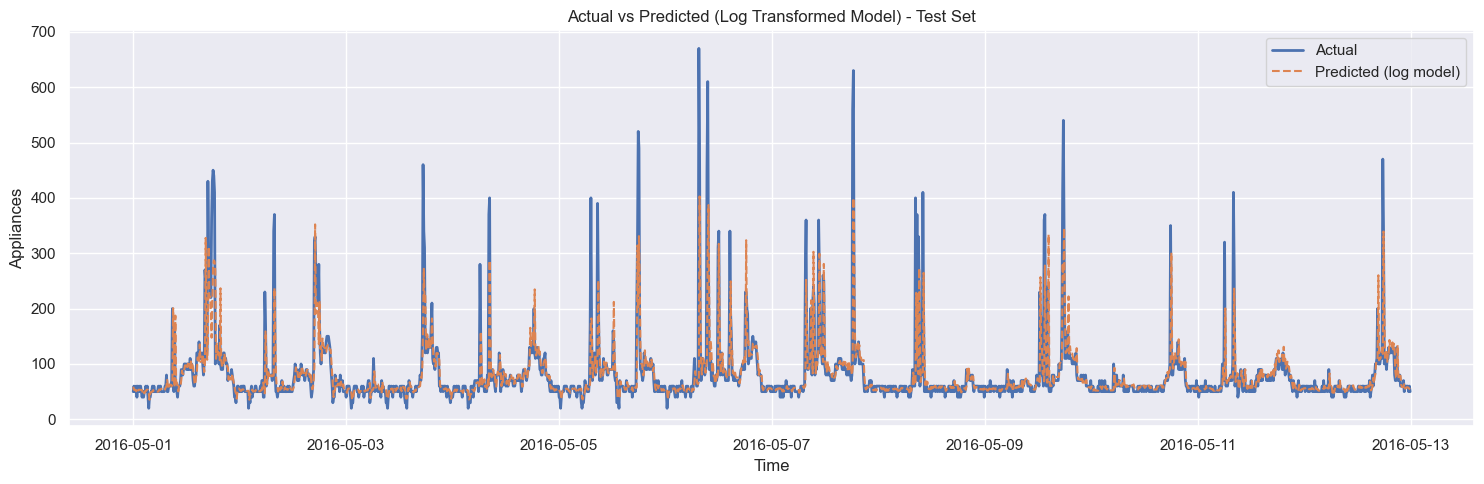

In [30]:
import matplotlib.pyplot as plt
import pandas as pd

# --- Full Test Range ---
plt.figure(figsize=(15, 5))
plt.plot(y_test.index, y_test, label='Actual', linewidth=2)
plt.plot(y_test.index, preds_test, label='Predicted (log model)', linestyle='--')
plt.title("Actual vs Predicted (Log Transformed Model) - Test Set")
plt.xlabel("Time")
plt.ylabel("Appliances")
plt.legend()
plt.tight_layout()
plt.show()


Observation: Shows some improvement but not magical.

### Recursive evaluation (Mimicking hold-out set prediction approach)

In [31]:
import pandas as pd
import numpy as np

# Make sure test set includes all raw columns required (including Appliances column, initially set to np.nan)
X_test_recursive = X_test.copy()
y_test_recursive = y_test.copy()
preds_recursive = []

# Keep a dynamic buffer of recent predictions (start from trainval target tail)
appl_buffer = list(y_trainval[-max(FeatureEngineer().lag_steps + FeatureEngineer().rolling_windows):])

for i in range(len(X_test_recursive)):
    row = X_test_recursive.iloc[i].copy()

    # === Update lag features ===
    for lag in FeatureEngineer().lag_steps:
        if len(appl_buffer) >= lag:
            row[f'Appliances_lag_{lag}'] = appl_buffer[-lag]
        else:
            row[f'Appliances_lag_{lag}'] = np.nan  # Shouldn't happen if buffer is long enough

    # === Update rolling means ===
    for window in FeatureEngineer().rolling_windows:
        if len(appl_buffer) >= window:
            row[f'Appliances_roll_mean_{window}'] = np.mean(appl_buffer[-window:])
        else:
            row[f'Appliances_roll_mean_{window}'] = np.nan

    # Drop if any lag/rolls are nan (shouldn’t happen after warmup)
    if row.isna().any():
        continue

    # Predict with the model
    pred_log = model_log.predict(row.to_frame().T)[0]
    pred = np.expm1(pred_log)  # inverse of log1p

    preds_recursive.append(pred)
    appl_buffer.append(pred)  # Update buffer with predicted value


In [32]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_true = y_test_recursive.iloc[:len(preds_recursive)]
mae = mean_absolute_error(y_true, preds_recursive)
rmse = mean_squared_error(y_true, preds_recursive, squared=False)
r2 = r2_score(y_true, preds_recursive)

print("\n📌 Recursive Forecast with Full Lag & Rolling Features")
print(f"Test MAE : {mae:.3f}")
print(f"Test RMSE: {rmse:.3f}")
print(f"Test R²  : {r2:.3f}")



📌 Recursive Forecast with Full Lag & Rolling Features
Test MAE : 41.195
Test RMSE: 72.869
Test R²  : -0.243


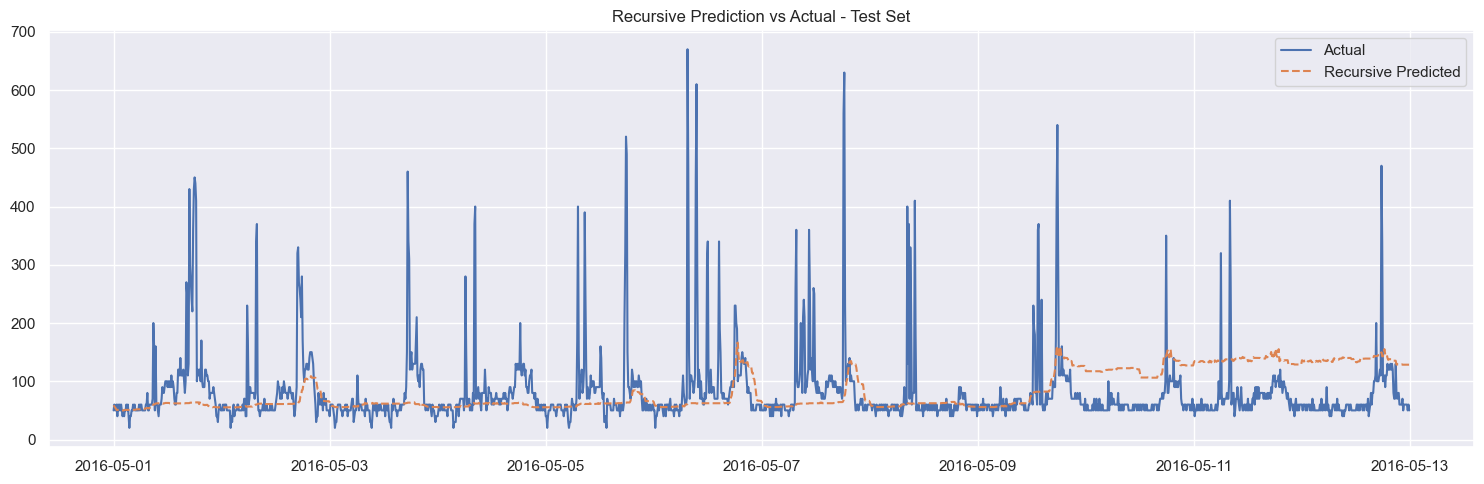

In [33]:
recursive_series = pd.Series(preds_recursive, index=y_true.index)

plt.figure(figsize=(15, 5))
plt.plot(y_true.index, y_true, label='Actual')
plt.plot(y_true.index, recursive_series, label='Recursive Predicted', linestyle='--')
plt.title("Recursive Prediction vs Actual - Test Set")
plt.legend()
plt.tight_layout()
plt.show()


- **Motivation:**
  - When the model was tested in a recursive (autoregressive) setting, where each prediction is fed back as the lagged input for the next step, performance dropped significantly.

- **Implementation:**
  - During test time, predictions for each time step were used to fill in lagged features for subsequent steps, simulating real deployment.
  - This approach exposed error accumulation and instability, especially for models heavily reliant on lagged target features.

- **Key Insight:**
  - Recursive evaluation is essential for honest assessment of time series models that use lagged target features.

## b. Explanatory variables only

As the true lagged Appliance values will not be available for the holdout set, experimenting with building a model only using the explanatory variables without using the lagged target features.

In [34]:
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# --- Step 1: Define train/test split ---
test_start_date = '2016-05-01'
df_trainval = df1_fe[df1_fe.index < test_start_date]
df_test = df1_fe[df1_fe.index >= test_start_date]

y_trainval = df_trainval['Appliances']
y_test = df_test['Appliances']

# --- Drop all 'Appliances_*' lag/rolling features from predictors ---
cols_to_drop = [col for col in df1_fe.columns if col.startswith('Appliances_')]
X_trainval = df_trainval.drop(columns=['Appliances'] + cols_to_drop)
X_test = df_test.drop(columns=['Appliances'] + cols_to_drop)

print(f"Train+Val range: {df_trainval.index.min()} → {df_trainval.index.max()} | Shape: {X_trainval.shape}")
print(f"Test range     : {df_test.index.min()} → {df_test.index.max()} | Shape: {X_test.shape}")

# --- Step 2: TSCV setup ---
tscv = TimeSeriesSplit(n_splits=5, gap=144)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity': -1,
    'seed': 42
}

mae_scores = []
rmse_scores = []
r2_scores = []
fold_models = []
best_iterations = []

# --- Step 3: Cross-Validation ---
for i, (train_idx, val_idx) in enumerate(tscv.split(X_trainval)):
    print(f"\nFold {i+1}")
    print(f"Train: {X_trainval.index[train_idx[0]]} → {X_trainval.index[train_idx[-1]]}")
    print(f"Valid: {X_trainval.index[val_idx[0]]} → {X_trainval.index[val_idx[-1]]}")

    X_train, X_val = X_trainval.iloc[train_idx], X_trainval.iloc[val_idx]
    y_train, y_val = y_trainval.iloc[train_idx], y_trainval.iloc[val_idx]

    dtrain = lgb.Dataset(X_train, y_train)
    dval = lgb.Dataset(X_val, y_val)

    model = lgb.train(
        params,
        dtrain,
        valid_sets=[dval],
        callbacks=[lgb.early_stopping(stopping_rounds=20)],
        num_boost_round=500
    )

    fold_models.append(model)
    best_iterations.append(model.best_iteration)

    preds_val = model.predict(X_val)
    mae_scores.append(mean_absolute_error(y_val, preds_val))
    rmse_scores.append(mean_squared_error(y_val, preds_val, squared=False))
    r2_scores.append(r2_score(y_val, preds_val))

    print(f"Fold {i+1} MAE: {mae_scores[-1]:.3f} | RMSE: {rmse_scores[-1]:.3f} | R²: {r2_scores[-1]:.3f}")

# --- Step 4: Summary of CV metrics ---
print("\n📌 Cross-Validation Summary (No Appliance Lags):")
print(f"Avg MAE : {np.mean(mae_scores):.3f}")
print(f"Avg RMSE: {np.mean(rmse_scores):.3f}")
print(f"Avg R²  : {np.mean(r2_scores):.3f}")

# --- Step 5: Retrain final model on all trainval data ---
best_iter_mean = int(np.mean(best_iterations))
final_model = lgb.train(params, lgb.Dataset(X_trainval, y_trainval), num_boost_round=best_iter_mean)

# Predict directly on test
preds_test = final_model.predict(X_test)


Train+Val range: 2016-01-12 17:00:00 → 2016-04-30 23:50:00 | Shape: (14442, 55)
Test range     : 2016-05-01 00:00:00 → 2016-05-12 23:50:00 | Shape: (1728, 55)

Fold 1
Train: 2016-01-12 17:00:00 → 2016-01-28 10:00:00
Valid: 2016-01-29 10:10:00 → 2016-02-15 03:10:00
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[4]	valid_0's rmse: 109.401
Fold 1 MAE: 69.938 | RMSE: 109.401 | R²: 0.012

Fold 2
Train: 2016-01-12 17:00:00 → 2016-02-14 03:10:00
Valid: 2016-02-15 03:20:00 → 2016-03-02 20:20:00
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[6]	valid_0's rmse: 92.887
Fold 2 MAE: 59.706 | RMSE: 92.887 | R²: 0.092

Fold 3
Train: 2016-01-12 17:00:00 → 2016-03-01 20:20:00
Valid: 2016-03-02 20:30:00 → 2016-03-28 13:30:00
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[12]	valid_0's rmse: 88.0839
Fold 3 MAE: 50.754 | RMSE: 88.084 | R²: 0.178

Fold 4
Trai


📌 Direct Model (No Appliance Lags) — Simulates Recursive Use
Test MAE : 65.805
Test RMSE: 100.258
Test R²  : -1.354


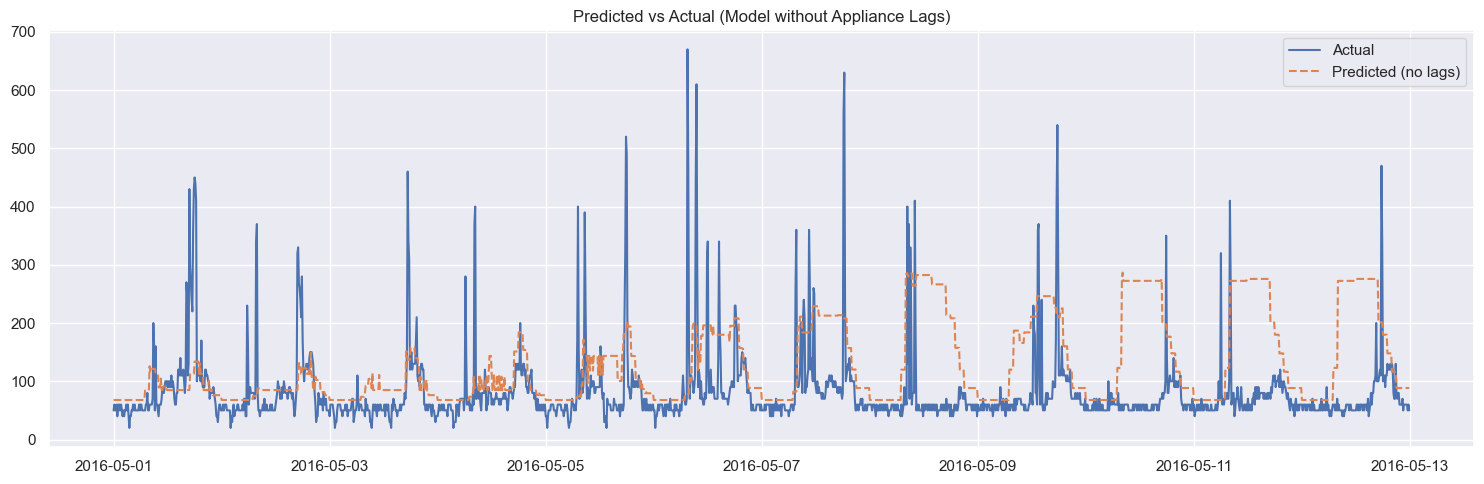

In [35]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd

# Same predictions as before — model doesn't need recursive lags
preds_recursive = preds_test  # Just for naming consistency

# Evaluate
mae = mean_absolute_error(y_test, preds_recursive)
rmse = mean_squared_error(y_test, preds_recursive, squared=False)
r2 = r2_score(y_test, preds_recursive)

print("\n📌 Direct Model (No Appliance Lags) — Simulates Recursive Use")
print(f"Test MAE : {mae:.3f}")
print(f"Test RMSE: {rmse:.3f}")
print(f"Test R²  : {r2:.3f}")

# Plot
pred_series = pd.Series(preds_recursive, index=y_test.index)

plt.figure(figsize=(15, 5))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, pred_series, label='Predicted (no lags)', linestyle='--')
plt.title("Predicted vs Actual (Model without Appliance Lags)")
plt.legend()
plt.tight_layout()
plt.show()


***Observation:***

b. External-Only Model
- **Features:**
  - Used only exogenous (external) variables—such as weather and calendar features—excluding all lagged target features.
- **Pros:**
  - No risk of error accumulation from recursive lags.
  - Stable predictions in deployment.
- **Cons:**
  - Prediction gets less and less accurate for longer time periods, failing to capture strong peaks.

## c. Short Lag (Only Appliance lag 1 and lag 2)

Including only shorter (10 min and 20 min) lags of the target to see if it improves the performance on longer periods.

In [36]:
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# --- Step 1: Define train/test split ---
test_start_date = '2016-05-01'
df_trainval = df1_fe[df1_fe.index < test_start_date]
df_test = df1_fe[df1_fe.index >= test_start_date]

y_trainval = df_trainval['Appliances']
y_test = df_test['Appliances']

# --- Step 2: Keep only selected lags (lag 1 & 2 + rolling)
short_lags = ['Appliances_lag_1', 'Appliances_lag_2']
roll_means = [col for col in df1_fe.columns if col.startswith('Appliances_roll_mean')]
non_appliance_cols = [col for col in df1_fe.columns if not col.startswith('Appliances_') and col != 'Appliances']

selected_features = short_lags + roll_means + non_appliance_cols

X_trainval = df_trainval[selected_features]
X_test = df_test[selected_features]

print(f"Train+Val shape: {X_trainval.shape}")
print(f"Test shape     : {X_test.shape}")

# --- Step 3: TimeSeriesSplit setup ---
tscv = TimeSeriesSplit(n_splits=5, gap=144)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity': -1,
    'seed': 42
}

mae_scores = []
rmse_scores = []
r2_scores = []
best_iterations = []

# --- Step 4: Cross-Validation ---
for i, (train_idx, val_idx) in enumerate(tscv.split(X_trainval)):
    print(f"\nFold {i+1}")
    X_train, X_val = X_trainval.iloc[train_idx], X_trainval.iloc[val_idx]
    y_train, y_val = y_trainval.iloc[train_idx], y_trainval.iloc[val_idx]

    dtrain = lgb.Dataset(X_train, y_train)
    dval = lgb.Dataset(X_val, y_val)

    model = lgb.train(
        params,
        dtrain,
        valid_sets=[dval],
        callbacks=[lgb.early_stopping(stopping_rounds=20)],
        num_boost_round=500
    )

    preds_val = model.predict(X_val)
    mae_scores.append(mean_absolute_error(y_val, preds_val))
    rmse_scores.append(mean_squared_error(y_val, preds_val, squared=False))
    r2_scores.append(r2_score(y_val, preds_val))
    best_iterations.append(model.best_iteration)

    print(f"Fold {i+1} MAE: {mae_scores[-1]:.2f} | RMSE: {rmse_scores[-1]:.2f} | R²: {r2_scores[-1]:.3f}")

# --- Step 5: Retrain on all train+val data ---
best_iter_avg = int(np.mean(best_iterations))
final_model = lgb.train(params, lgb.Dataset(X_trainval, y_trainval), num_boost_round=best_iter_avg)

# Predict on test set
preds_test = final_model.predict(X_test)


Train+Val shape: (14442, 59)
Test shape     : (1728, 59)

Fold 1
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[18]	valid_0's rmse: 73.5962
Fold 1 MAE: 42.32 | RMSE: 73.60 | R²: 0.553

Fold 2
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[17]	valid_0's rmse: 67.0086
Fold 2 MAE: 33.02 | RMSE: 67.01 | R²: 0.527

Fold 3
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[49]	valid_0's rmse: 62.2826
Fold 3 MAE: 28.11 | RMSE: 62.28 | R²: 0.589

Fold 4
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[32]	valid_0's rmse: 61.7853
Fold 4 MAE: 27.26 | RMSE: 61.79 | R²: 0.623

Fold 5
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[29]	valid_0's rmse: 62.7977
Fold 5 MAE: 28.84 | RMSE: 62.80 | R²: 0.628



📌 Final Model with Short Lags (lag_1, lag_2, rolling)
Test MAE : 23.43
Test RMSE: 51.15
Test R²  : 0.387


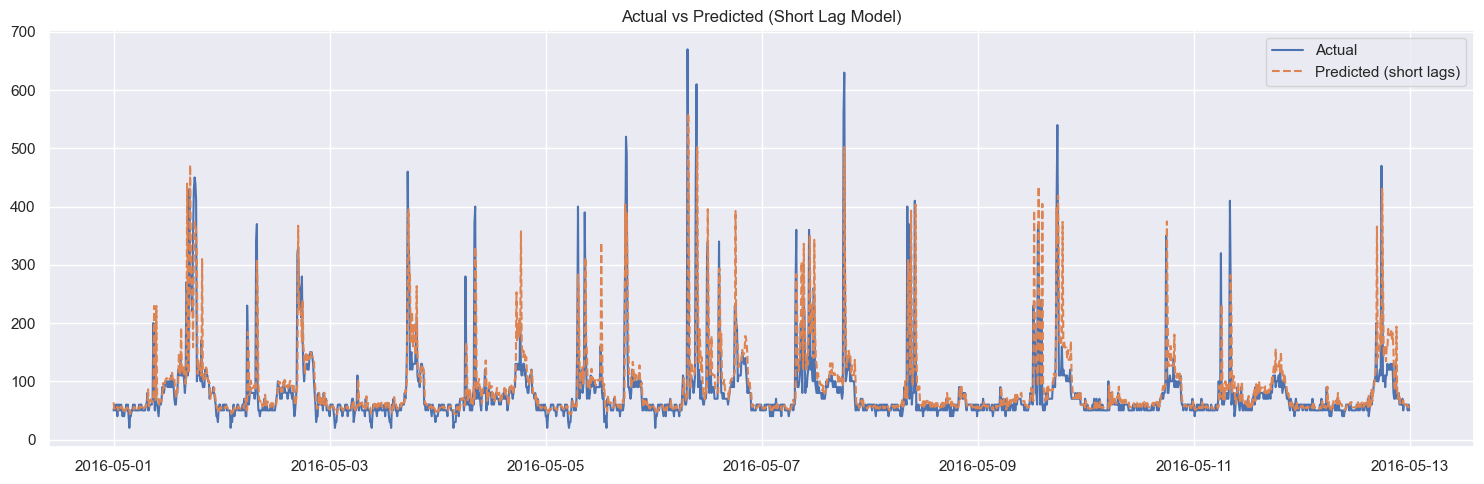

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

mae = mean_absolute_error(y_test, preds_test)
rmse = mean_squared_error(y_test, preds_test, squared=False)
r2 = r2_score(y_test, preds_test)

print("\n📌 Final Model with Short Lags (lag_1, lag_2, rolling)")
print(f"Test MAE : {mae:.2f}")
print(f"Test RMSE: {rmse:.2f}")
print(f"Test R²  : {r2:.3f}")

# Plot
plt.figure(figsize=(15, 5))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, pd.Series(preds_test, index=y_test.index), label='Predicted (short lags)', linestyle='--')
plt.title("Actual vs Predicted (Short Lag Model)")
plt.legend()
plt.tight_layout()
plt.show()


Recursive evaluation provided below

In [38]:
# Copy to avoid overwriting
X_test_rec = X_test.copy()
y_test_rec = y_test.copy()
preds_recursive = []

# Start with tail of true values from trainval for lag/rolling warmup
warmup_lags = y_trainval[-144:].tolist()  # longest lag or rolling window needed

# Get rolling feature names
rolling_cols = [col for col in X_test_rec.columns if "roll_mean" in col]

for i in range(len(X_test_rec)):
    row = X_test_rec.iloc[i].copy()

    # --- Update lag features ---
    if len(warmup_lags) >= 2:
        row['Appliances_lag_1'] = warmup_lags[-1]
        row['Appliances_lag_2'] = warmup_lags[-2]

    # --- Update rolling mean features ---
    for col in rolling_cols:
        window = int(col.split('_')[-1])  # e.g., 6 or 18
        if len(warmup_lags) >= window:
            row[col] = np.mean(warmup_lags[-window:])
        else:
            row[col] = np.mean(warmup_lags)  # fallback to shorter mean

    # Predict using the trained model
    pred = final_model.predict(row.to_frame().T)[0]
    preds_recursive.append(pred)

    # Update warmup buffer with the prediction
    warmup_lags.append(pred)

# Align predictions with test index
preds_recursive_series = pd.Series(preds_recursive, index=y_test_rec.index[:len(preds_recursive)])


In [39]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Ensure true target matches prediction length
y_true = y_test_rec.iloc[:len(preds_recursive)]

# Convert to Series for easy alignment (optional)
preds_recursive_series = pd.Series(preds_recursive, index=y_true.index)

# --- Calculate metrics ---
mae_rec = mean_absolute_error(y_true, preds_recursive_series)
rmse_rec = mean_squared_error(y_true, preds_recursive_series, squared=False)
r2_rec = r2_score(y_true, preds_recursive_series)

# --- Print results ---
print("\n📌 Recursive Forecast Evaluation (Short Lag Model)")
print(f"Test MAE : {mae_rec:.2f}")
print(f"Test RMSE: {rmse_rec:.2f}")
print(f"Test R²  : {r2_rec:.3f}")



📌 Recursive Forecast Evaluation (Short Lag Model)
Test MAE : 89.43
Test RMSE: 98.62
Test R²  : -1.277


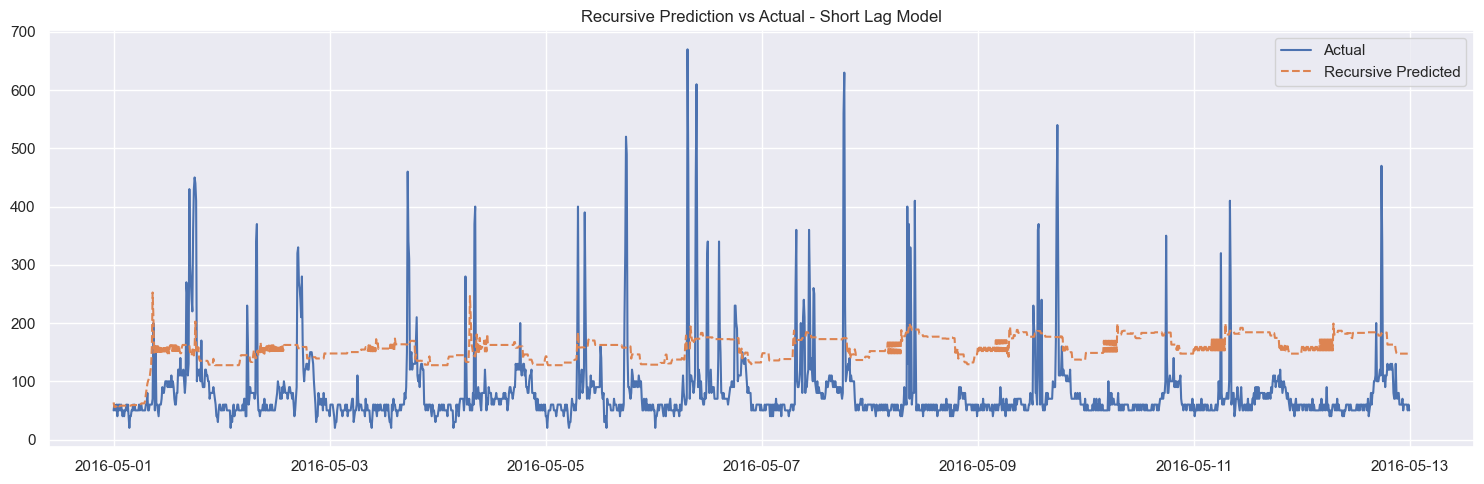

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(y_true.index, y_true, label='Actual')
plt.plot(y_true.index, preds_recursive_series, label='Recursive Predicted', linestyle='--')
plt.title("Recursive Prediction vs Actual - Short Lag Model")
plt.legend()
plt.tight_layout()
plt.show()


***Observation:***

### c. Short-Lag Model
- **Features:**
  - Included only short-term lags (e.g., lag 1, lag 2, and rolling means (excl current day)) of the target, plus external features.
- **Pros:**
  - Balances use of autoregressive information with reduced risk of runaway error.
- **Cons:**
  - Still susceptible to some error accumulation, but more stable than full-lag models.


***Conclusion:*** Using only explanatory variables appears to be a valid modeling choice, as this approach captured short-term trends (particularly within a one-week window) more effectively than the alternatives.

______
## Step 5: Ensemble approach (only on explanatory variables)

**Motivation:**
  - Standard regression models struggled to accurately predict rare, high-usage (peak) events.

**Method:**
  - Built a two-stage ensemble:
    1. **Peak Classifier:** A classifier predicts whether each time step is a peak (above the 95th percentile).
    2. **Two Regressors:**
       - One regressor for non-peak periods (standard regression).
       - One regressor for peak periods (quantile regression, oversampled for peaks).
    3. **Weighted Blending:**
       - Final prediction is a weighted average of the two regressors, using the classifier's probability of a peak.

**Enhancements:**
- Added interaction features (e.g., temperature × hour, windspeed × weekend) to improve model expressiveness.
- Used quantile regression for the peak regressor.
- Adjusted classifier thresholds for more sensitive peak detection.

**Evaluation:**
- Ensemble models were evaluated in recursive settings.
- Showed improved performance on peak events and better overall stability.

In [41]:
# List of external variables (customize as needed)
external_cols = [
    'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'RH_4', 'T5', 'RH_5',
    'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9', 'T_out',
    'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility', 'Tdewpoint'
]

for col in external_cols:
    for window in [6, 18]:  # 1h, 3h
        df1_fe[f'{col}_roll_mean_{window}'] = df1_fe[col].rolling(window).mean()
        df1_fe[f'{col}_roll_max_{window}'] = df1_fe[col].rolling(window).max()
        df1_fe[f'{col}_roll_min_{window}'] = df1_fe[col].rolling(window).min()
        df1_fe[f'{col}_roll_std_{window}'] = df1_fe[col].rolling(window).std()

# Drop rows with any NaN (due to rolling windows)
df1_fe = df1_fe.dropna()

In [42]:
# Define train/test split as before
test_start_date = '2016-05-01'
df_trainval = df1_fe[df1_fe.index < test_start_date]
df_test = df1_fe[df1_fe.index >= test_start_date]

y_trainval = df_trainval['Appliances']
y_test = df_test['Appliances']

# Create peak label (95th percentile)
peak_threshold = y_trainval.quantile(0.95)
df_trainval['is_peak'] = (y_trainval > peak_threshold).astype(int)

In [43]:
# Drop all 'Appliances_*' lag/rolling features from predictors
cols_to_drop = [col for col in df1_fe.columns if col.startswith('Appliances_')]
X_trainval = df_trainval.drop(columns=['Appliances', 'is_peak'] + cols_to_drop)
X_test = df_test.drop(columns=['Appliances'] + cols_to_drop)

In [44]:
feature_list = X_trainval.columns.tolist()
import joblib
joblib.dump(feature_list, 'ensemble_feature_list.joblib')

['ensemble_feature_list.joblib']

In [45]:
from lightgbm import LGBMClassifier, LGBMRegressor

# Classifier for peak detection
clf = LGBMClassifier(random_state=42)
clf.fit(X_trainval, df_trainval['is_peak'])

# Two regressors
reg_nonpeak = LGBMRegressor(random_state=42)
reg_peak = LGBMRegressor(random_state=42)

reg_nonpeak.fit(X_trainval[df_trainval['is_peak'] == 0], y_trainval[df_trainval['is_peak'] == 0])
reg_peak.fit(X_trainval[df_trainval['is_peak'] == 1], y_trainval[df_trainval['is_peak'] == 1])

LGBMRegressor(random_state=42)

In [46]:
import numpy as np

preds_ensemble = []
for i in range(len(X_test)):
    x = X_test.iloc[i]
    is_peak_pred = clf.predict(x.values.reshape(1, -1))[0]
    if is_peak_pred:
        pred = reg_peak.predict(x.values.reshape(1, -1))[0]
    else:
        pred = reg_nonpeak.predict(x.values.reshape(1, -1))[0]
    preds_ensemble.append(pred)

# Convert to Series for easy comparison
import pandas as pd
preds_ensemble_series = pd.Series(preds_ensemble, index=y_test.index)


📌 Ensemble Model (Classifier + Two Regressors)
Test MAE : 34.42
Test RMSE: 63.50
Test R²  : 0.056


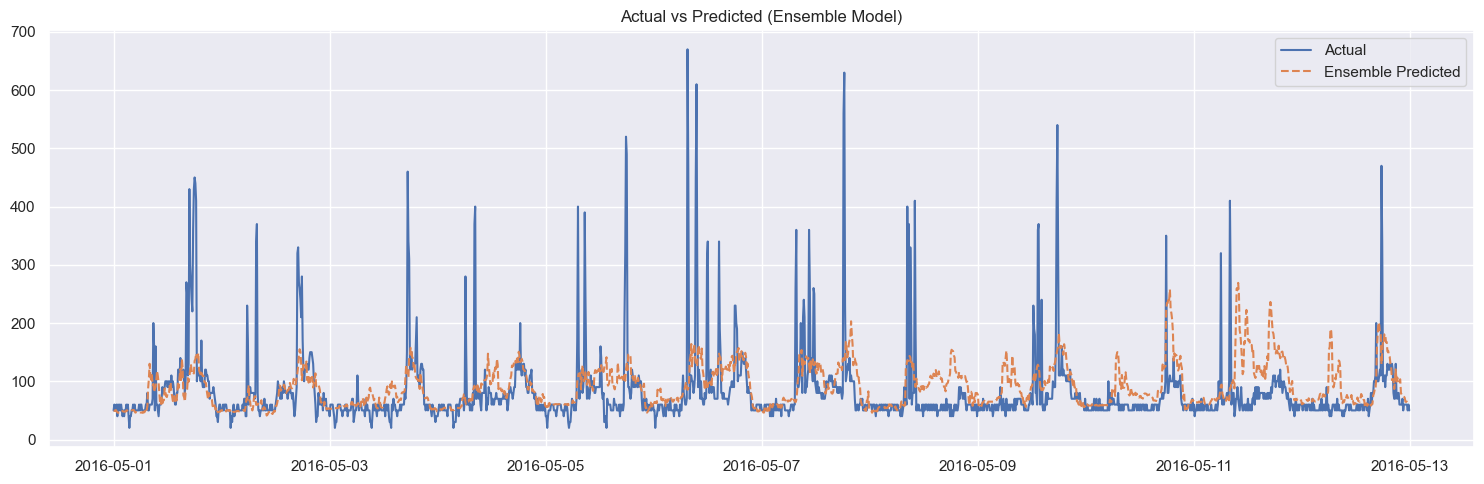

In [47]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

mae = mean_absolute_error(y_test, preds_ensemble_series)
rmse = mean_squared_error(y_test, preds_ensemble_series, squared=False)
r2 = r2_score(y_test, preds_ensemble_series)

print("\n📌 Ensemble Model (Classifier + Two Regressors)")
print(f"Test MAE : {mae:.2f}")
print(f"Test RMSE: {rmse:.2f}")
print(f"Test R²  : {r2:.3f}")

plt.figure(figsize=(15, 5))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, preds_ensemble_series, label='Ensemble Predicted', linestyle='--')
plt.title("Actual vs Predicted (Ensemble Model)")
plt.legend()
plt.tight_layout()
plt.show()

Observation: Model is not capturing peaks that well

## Quantile Regression for Peak Sensitivity

In [48]:
from lightgbm import LGBMRegressor
from sklearn.utils import resample

# Oversample peak data for the peak regressor
X_peak = X_trainval[df_trainval['is_peak'] == 1]
y_peak = y_trainval[df_trainval['is_peak'] == 1]
X_peak_oversampled, y_peak_oversampled = resample(
    X_peak, y_peak, replace=True, n_samples=len(X_peak)*3, random_state=42
)

# Non-peak regressor (standard)
reg_nonpeak = LGBMRegressor(random_state=42)
reg_nonpeak.fit(X_trainval[df_trainval['is_peak'] == 0], y_trainval[df_trainval['is_peak'] == 0])

# Peak regressor (quantile regression, 90th percentile)
reg_peak = LGBMRegressor(objective='quantile', alpha=0.9, random_state=42)
reg_peak.fit(X_peak_oversampled, y_peak_oversampled)

LGBMRegressor(alpha=0.9, objective='quantile', random_state=42)


📌 Weighted Ensemble (Quantile Peak Regressor, Oversampled Peaks)
Test MAE : 37.34
Test RMSE: 64.22
Test R²  : 0.034


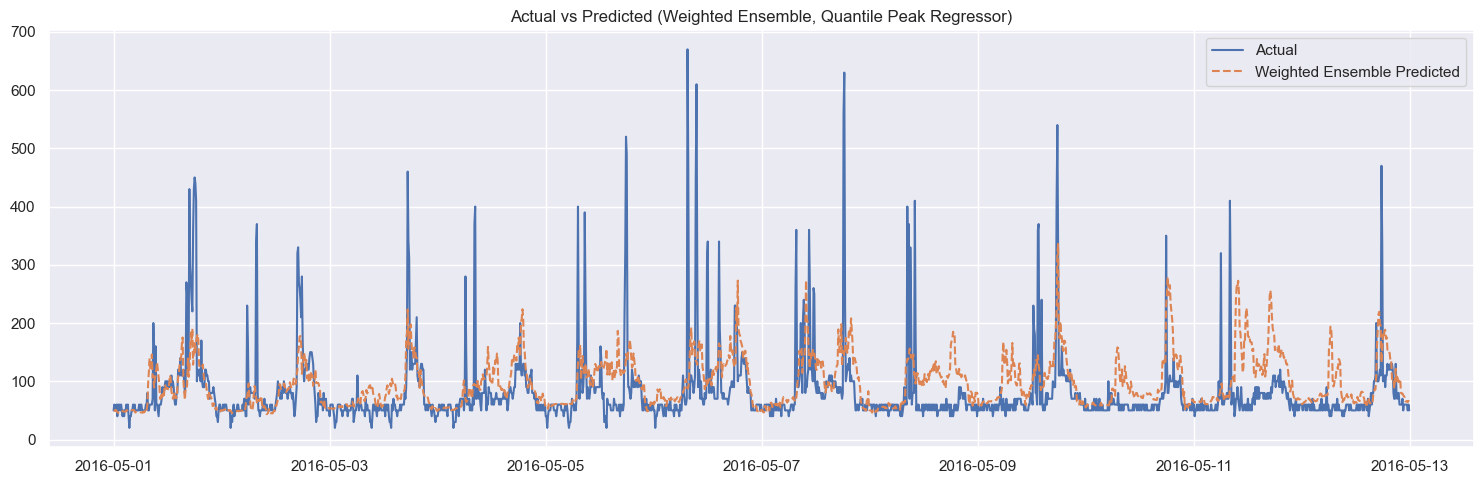

In [49]:
# Use classifier's predicted probability to blend regressors
preds_ensemble_weighted = []
probs = clf.predict_proba(X_test)[:, 1]  # Probability of being a peak

for i in range(len(X_test)):
    x = X_test.iloc[i]
    prob_peak = probs[i]
    pred_peak = reg_peak.predict(x.values.reshape(1, -1))[0]
    pred_nonpeak = reg_nonpeak.predict(x.values.reshape(1, -1))[0]
    # Weighted average: more weight to peak regressor if prob_peak is high
    pred = prob_peak * pred_peak + (1 - prob_peak) * pred_nonpeak
    preds_ensemble_weighted.append(pred)

# Convert to Series for easy comparison
import pandas as pd
preds_ensemble_weighted_series = pd.Series(preds_ensemble_weighted, index=y_test.index)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

mae = mean_absolute_error(y_test, preds_ensemble_weighted_series)
rmse = mean_squared_error(y_test, preds_ensemble_weighted_series, squared=False)
r2 = r2_score(y_test, preds_ensemble_weighted_series)

print("\n📌 Weighted Ensemble (Quantile Peak Regressor, Oversampled Peaks)")
print(f"Test MAE : {mae:.2f}")
print(f"Test RMSE: {rmse:.2f}")
print(f"Test R²  : {r2:.3f}")

plt.figure(figsize=(15, 5))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, preds_ensemble_weighted_series, label='Weighted Ensemble Predicted', linestyle='--')
plt.title("Actual vs Predicted (Weighted Ensemble, Quantile Peak Regressor)")
plt.legend()
plt.tight_layout()
plt.show()


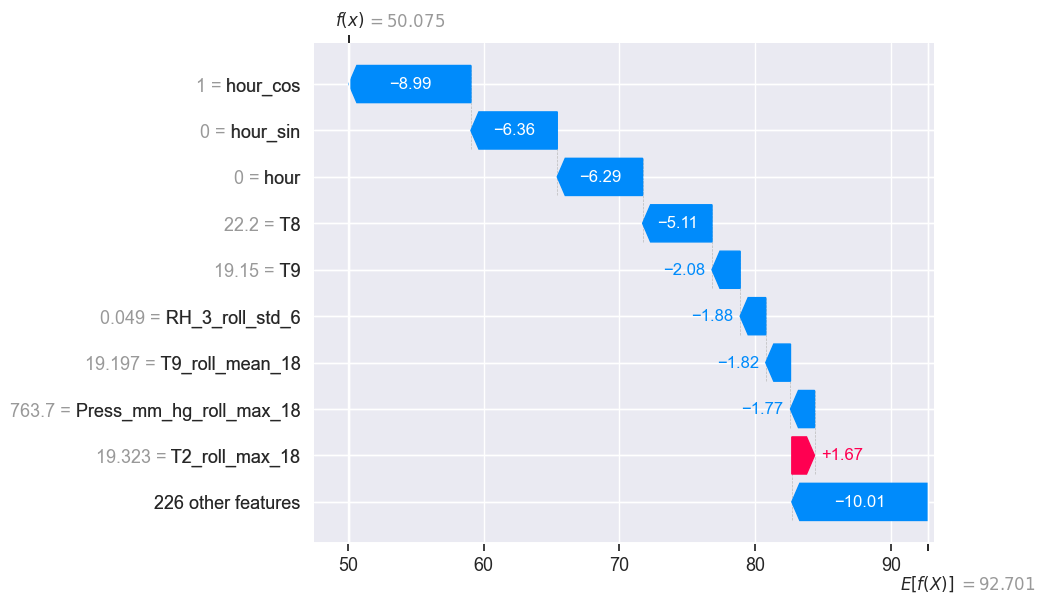

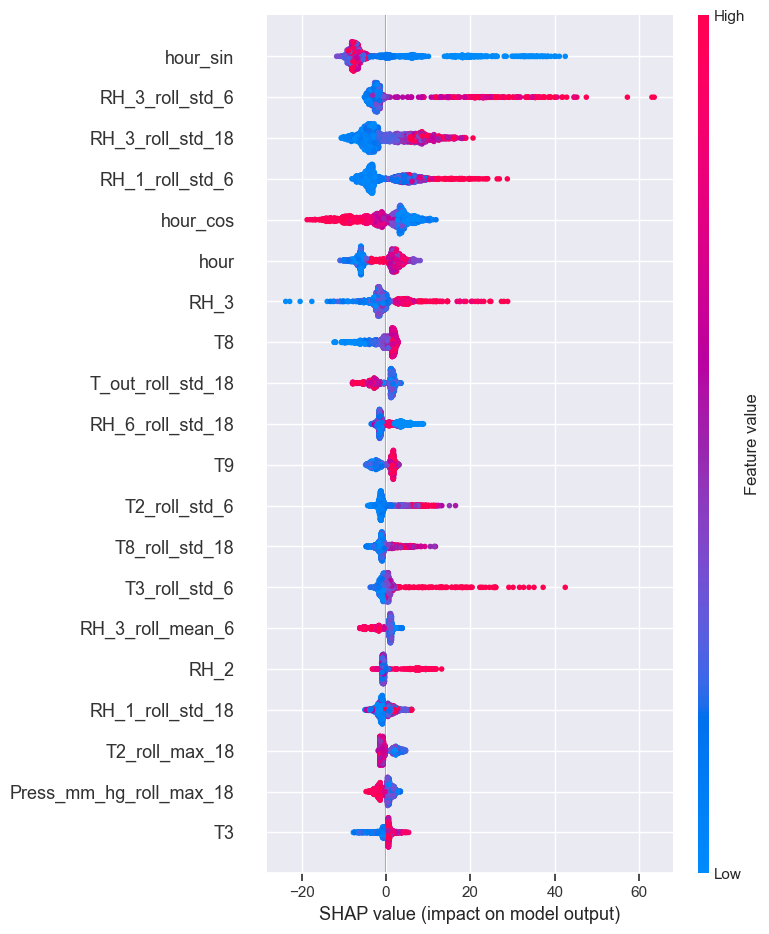

In [50]:

# --- SHAP Waterfall and Summary Plot for reg_nonpeak ---
import shap

explainer = shap.Explainer(reg_nonpeak, X_test)
shap_values = explainer(X_test, check_additivity=False)

# Waterfall plot for the first test sample
shap.plots.waterfall(shap_values[0])

# Summary plot for global feature importance
shap.summary_plot(shap_values, X_test)

***Observation:*** Average performance degraded slightly but if we see the graph, earlier periods are capturing the peaks more accurately. Therefore, model selection will depend on understanding the trade-off between average performance or early period (around one week) accuracy.

**SHAP** analysis reveals that the model relies heavily on time-of-day features (hour_sin, hour_cos, hour) and recent variability in environmental conditions (rolling standard deviations of humidity and temperature) to predict household appliance usage. For individual predictions, these features can significantly increase or decrease the forecasted value, and their global importance is confirmed by the summary plot.

## Model Saving

Saving this model as it was selected as the final model for this task after discussion in later stages.

In [51]:
import joblib

# --- Save the three components of the ensemble model ---
joblib.dump(clf, 'peak_classifier.joblib')
joblib.dump(reg_nonpeak, 'regressor_nonpeak.joblib')
joblib.dump(reg_peak, 'regressor_peak.joblib')

print("Models saved successfully.")

Models saved successfully.


## Higher quantile for the peak regressor - using alpha=0.98 (98th percentile) for the quantile regression.

Experimenting with higher percentile to see if it improves peak sensitivity.


📌 Weighted Ensemble (Quantile Peak Regressor, alpha=0.98, threshold=0.3, with Interactions)
Test MAE : 39.91
Test RMSE: 64.86
Test R²  : 0.015


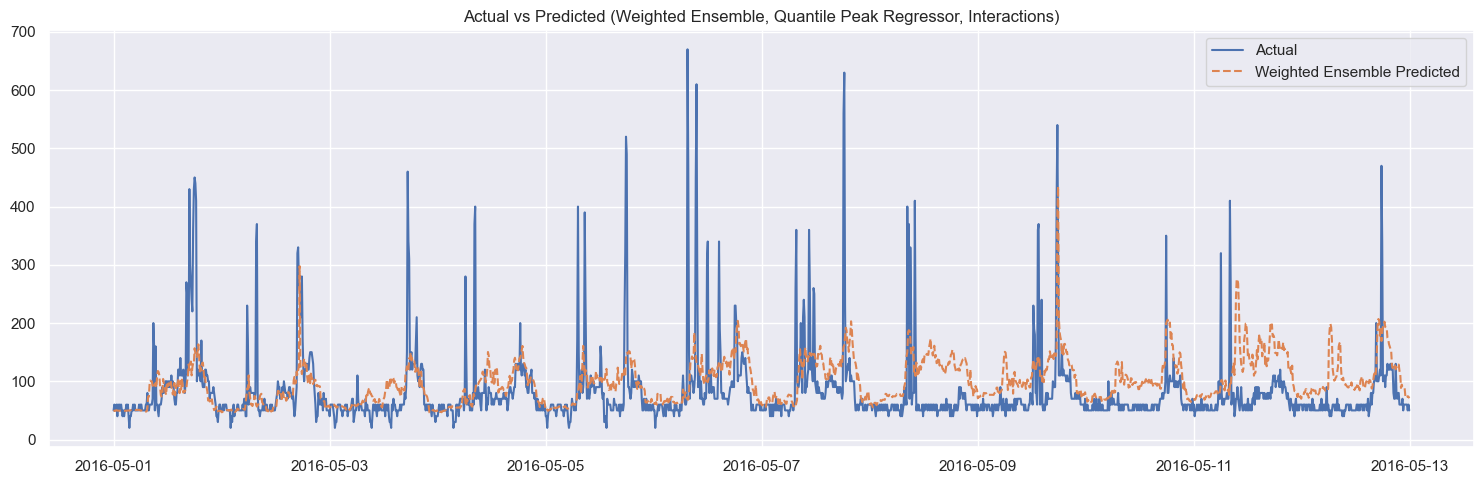

In [52]:
# --- Enhanced Feature Engineering: Add interaction features ---
# Example interactions: temperature x hour, humidity x weekend, windspeed x hour
for col in ['T_out', 'RH_out', 'Windspeed']:
    df1_fe[f'{col}_x_hour'] = df1_fe[col] * df1_fe['hour']
    df1_fe[f'{col}_x_weekend'] = df1_fe[col] * df1_fe['is_weekend']

# --- (Re-)split train/test after new features ---
test_start_date = '2016-05-01'
df_trainval = df1_fe[df1_fe.index < test_start_date]
df_test = df1_fe[df1_fe.index >= test_start_date]

y_trainval = df_trainval['Appliances']
y_test = df_test['Appliances']

# Create peak label (95th percentile)
peak_threshold = y_trainval.quantile(0.95)
df_trainval['is_peak'] = (y_trainval > peak_threshold).astype(int)

# Drop all 'Appliances_*' lag/rolling features from predictors
cols_to_drop = [col for col in df1_fe.columns if col.startswith('Appliances_')]
X_trainval = df_trainval.drop(columns=['Appliances', 'is_peak'] + cols_to_drop)
X_test = df_test.drop(columns=['Appliances'] + cols_to_drop)

# --- Train Classifier and Regressors ---
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.utils import resample

clf = LGBMClassifier(random_state=42)
clf.fit(X_trainval, df_trainval['is_peak'])

# Oversample peak data for the peak regressor
X_peak = X_trainval[df_trainval['is_peak'] == 1]
y_peak = y_trainval[df_trainval['is_peak'] == 1]
X_peak_oversampled, y_peak_oversampled = resample(
    X_peak, y_peak, replace=True, n_samples=len(X_peak)*3, random_state=42
)

# Non-peak regressor (standard)
reg_nonpeak = LGBMRegressor(random_state=42)
reg_nonpeak.fit(X_trainval[df_trainval['is_peak'] == 0], y_trainval[df_trainval['is_peak'] == 0])

# Peak regressor (quantile regression, 98th percentile)
reg_peak = LGBMRegressor(objective='quantile', alpha=0.98, random_state=42)
reg_peak.fit(X_peak_oversampled, y_peak_oversampled)

# --- Weighted Ensemble Using Lower Classifier Threshold ---
probs = clf.predict_proba(X_test)[:, 1]
threshold = 0.3  # more aggressive
preds_ensemble_weighted = []
for i in range(len(X_test)):
    x = X_test.iloc[i]
    prob_peak = probs[i]
    pred_peak = reg_peak.predict(x.values.reshape(1, -1))[0]
    pred_nonpeak = reg_nonpeak.predict(x.values.reshape(1, -1))[0]
    # Use threshold to switch or blend
    if prob_peak > threshold:
        pred = prob_peak * pred_peak + (1 - prob_peak) * pred_nonpeak
    else:
        pred = pred_nonpeak
    preds_ensemble_weighted.append(pred)

# Convert to Series for easy comparison
import pandas as pd
preds_ensemble_weighted_series = pd.Series(preds_ensemble_weighted, index=y_test.index)

# --- Evaluate and Plot ---
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

mae = mean_absolute_error(y_test, preds_ensemble_weighted_series)
rmse = mean_squared_error(y_test, preds_ensemble_weighted_series, squared=False)
r2 = r2_score(y_test, preds_ensemble_weighted_series)

print("\n📌 Weighted Ensemble (Quantile Peak Regressor, alpha=0.98, threshold=0.3, with Interactions)")
print(f"Test MAE : {mae:.2f}")
print(f"Test RMSE: {rmse:.2f}")
print(f"Test R²  : {r2:.3f}")

plt.figure(figsize=(15, 5))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, preds_ensemble_weighted_series, label='Weighted Ensemble Predicted', linestyle='--')
plt.title("Actual vs Predicted (Weighted Ensemble, Quantile Peak Regressor, Interactions)")
plt.legend()
plt.tight_layout()
plt.show()


## Trial Model Enhancement: Hybrid Recursive Model 

Now that explanatory variables-only model has been enhanced, experimenting with adding lagged target variables to see if it improves model performance and peak sensitivity.

In [53]:
# Create a fresh copy to work with
df_recursive = df1_interp.copy()

# --- Feature Engineering with Appliance Lags ---
# 1. Time-based features
df_recursive['hour'] = df_recursive.index.hour
df_recursive['dayofweek'] = df_recursive.index.dayofweek
df_recursive['is_weekend'] = (df_recursive['dayofweek'] >= 5).astype(int)

# 2. Lag features for Appliances (target)
lag_steps = [1, 2, 3, 6, 12, 144] # up to 24h ago
for lag in lag_steps:
    df_recursive[f'Appliances_lag_{lag}'] = df_recursive['Appliances'].shift(lag)

# 3. Rolling means for Appliances (shifted to avoid leakage)
rolling_windows = [6, 18] # 1h and 3h
for window in rolling_windows:
    df_recursive[f'Appliances_roll_mean_{window}'] = df_recursive['Appliances'].shift(1).rolling(window).mean()

# 4. Rolling stats for key external predictors
for col in ['T_out', 'RH_out', 'Windspeed']:
    for window in [6, 18]:
        df_recursive[f'{col}_roll_mean_{window}'] = df_recursive[col].rolling(window).mean()
        df_recursive[f'{col}_roll_max_{window}'] = df_recursive[col].rolling(window).max()
        df_recursive[f'{col}_roll_min_{window}'] = df_recursive[col].rolling(window).min()
        df_recursive[f'{col}_roll_std_{window}'] = df_recursive[col].rolling(window).std()

# 5. Interaction features
for col in ['T_out', 'RH_out', 'Windspeed']:
    df_recursive[f'{col}_x_hour'] = df_recursive[col] * df_recursive['hour']

# Drop NaNs created by lags/rolling windows
df_recursive = df_recursive.dropna()


# --- Split and Train ---
test_start_date = '2016-05-01'
df_trainval = df_recursive[df_recursive.index < test_start_date]
df_test = df_recursive[df_recursive.index >= test_start_date]

y_trainval = df_trainval['Appliances']
y_test = df_test['Appliances']

# Define peak label
peak_threshold = y_trainval.quantile(0.95)
df_trainval['is_peak'] = (y_trainval > peak_threshold).astype(int)

# Define features (this time including Appliance lags)
X_trainval = df_trainval.drop(columns=['Appliances', 'is_peak'])
X_test = df_test.drop(columns=['Appliances'])


# --- Train the Classifier and Regressors ---
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.utils import resample

# Classifier
clf = LGBMClassifier(random_state=42)
clf.fit(X_trainval, df_trainval['is_peak'])

# Oversample peak data for the peak regressor
X_peak = X_trainval[df_trainval['is_peak'] == 1]
y_peak = y_trainval[df_trainval['is_peak'] == 1]
X_peak_oversampled, y_peak_oversampled = resample(
    X_peak, y_peak, replace=True, n_samples=len(X_peak) * 3, random_state=42
)

# Regressors
reg_nonpeak = LGBMRegressor(random_state=42)
reg_nonpeak.fit(X_trainval[df_trainval['is_peak'] == 0], y_trainval[df_trainval['is_peak'] == 0])

reg_peak = LGBMRegressor(objective='quantile', alpha=0.95, random_state=42) # Using 0.95 quantile
reg_peak.fit(X_peak_oversampled, y_peak_oversampled)

LGBMRegressor(alpha=0.95, objective='quantile', random_state=42)


📌 Final Hybrid Recursive Model
Test MAE : 49.63
Test RMSE: 98.22
Test R²  : -1.259


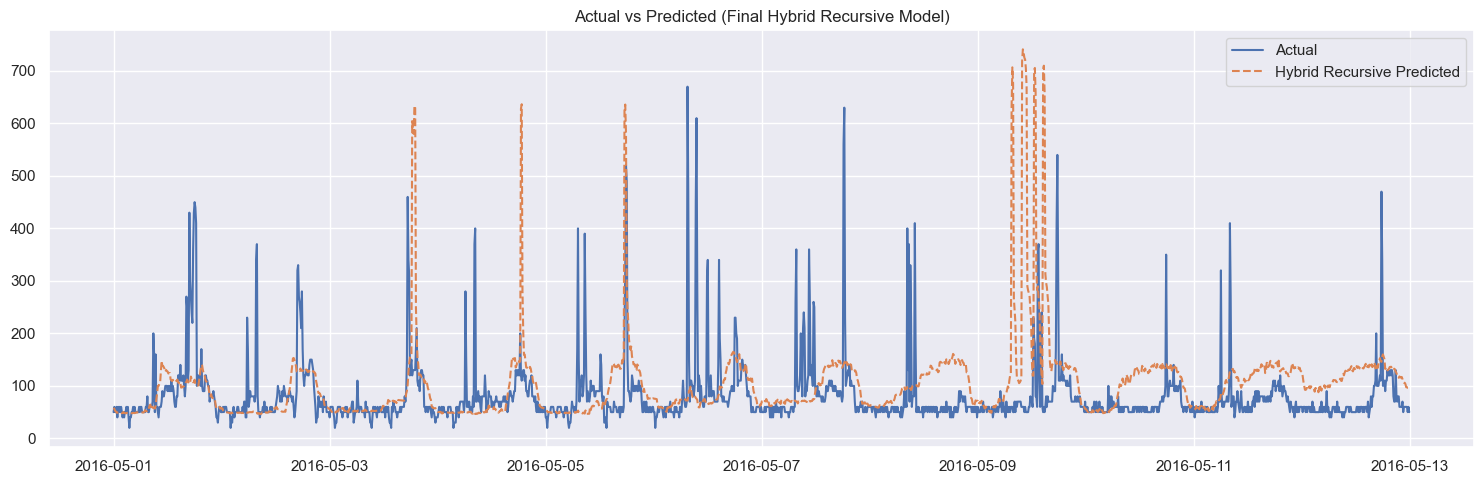

In [54]:
import numpy as np

# Initialize a history buffer with the tail of the training data
history = y_trainval.tolist()
preds_recursive_final = []

# Get a copy of the test features to modify in the loop
X_test_loop = X_test.copy()

for i in range(len(X_test_loop)):
    # Get current feature row
    current_features = X_test_loop.iloc[i:i+1].copy()

    # --- Update Appliance lag and rolling features from history ---
    for lag in lag_steps:
        current_features[f'Appliances_lag_{lag}'] = history[-lag]
    for window in rolling_windows:
        current_features[f'Appliances_roll_mean_{window}'] = np.mean(history[-window:])

    # --- Predict using the ensemble ---
    prob_peak = clf.predict_proba(current_features)[:, 1][0]
    threshold = 0.4 # Tune this threshold

    if prob_peak > threshold:
        pred = reg_peak.predict(current_features)[0]
    else:
        pred = reg_nonpeak.predict(current_features)[0]

    # Append prediction to our list and update the history
    preds_recursive_final.append(pred)
    history.append(pred)

# --- Evaluate and Plot ---
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

preds_recursive_series = pd.Series(preds_recursive_final, index=y_test.index)

mae = mean_absolute_error(y_test, preds_recursive_series)
rmse = mean_squared_error(y_test, preds_recursive_series, squared=False)
r2 = r2_score(y_test, preds_recursive_series)

print("\n📌 Final Hybrid Recursive Model")
print(f"Test MAE : {mae:.2f}")
print(f"Test RMSE: {rmse:.2f}")
print(f"Test R²  : {r2:.3f}")

plt.figure(figsize=(15, 5))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, preds_recursive_series, label='Hybrid Recursive Predicted', linestyle='--')
plt.title("Actual vs Predicted (Final Hybrid Recursive Model)")
plt.legend()
plt.tight_layout()
plt.show()

As the above result appears to be unstable, experimenting with stability control below.

In [55]:
# (Use the same feature engineering and train/test split as the previous step)
# df_recursive, X_trainval, y_trainval, X_test, y_test should already be defined.

# --- Train the Classifier and a More Stable Regressor ---
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.utils import resample

# Classifier (same as before)
clf = LGBMClassifier(random_state=42)
clf.fit(X_trainval, df_trainval['is_peak'])

# Oversample peak data (same as before)
X_peak = X_trainval[df_trainval['is_peak'] == 1]
y_peak = y_trainval[df_trainval['is_peak'] == 1]
X_peak_oversampled, y_peak_oversampled = resample(
    X_peak, y_peak, replace=True, n_samples=len(X_peak) * 3, random_state=42
)

# Regressors
reg_nonpeak = LGBMRegressor(random_state=42)
reg_nonpeak.fit(X_trainval[df_trainval['is_peak'] == 0], y_trainval[df_trainval['is_peak'] == 0])

# **Change**: Peak regressor is now slightly less aggressive (alpha=0.90)
reg_peak = LGBMRegressor(objective='quantile', alpha=0.90, random_state=42)
reg_peak.fit(X_peak_oversampled, y_peak_oversampled)

LGBMRegressor(alpha=0.9, objective='quantile', random_state=42)


📌 Stabilized Hybrid Recursive Model
Test MAE : 46.06
Test RMSE: 89.40
Test R²  : -0.872


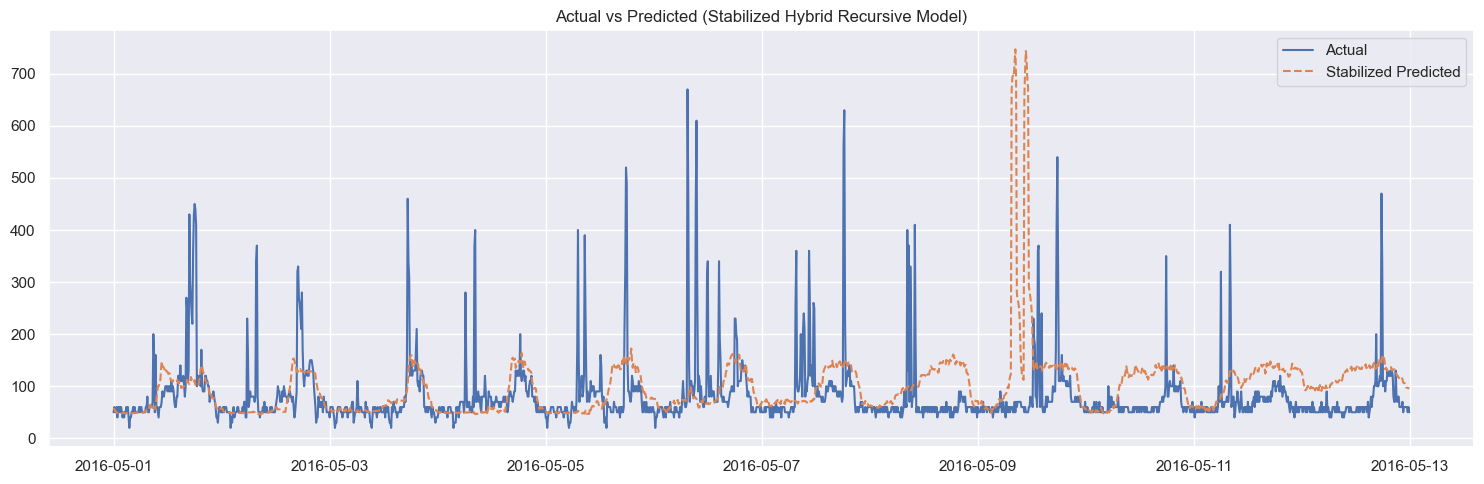

In [56]:
import numpy as np

# Initialize history buffer
history = y_trainval.tolist()
# Define a reasonable maximum value for predictions
max_pred_value = y_trainval.max() # Cap predictions at the max value seen in training
preds_stabilized = []

X_test_loop = X_test.copy()

for i in range(len(X_test_loop)):
    # Get current feature row
    current_features = X_test_loop.iloc[i:i+1].copy()

    # Update Appliance lag/rolling features from history
    for lag in lag_steps:
        current_features[f'Appliances_lag_{lag}'] = history[-lag]
    for window in rolling_windows:
        current_features[f'Appliances_roll_mean_{window}'] = np.mean(history[-window:])

    # Predict using the ensemble
    prob_peak = clf.predict_proba(current_features)[:, 1][0]
    threshold = 0.5 # Resetting to a more conservative threshold

    if prob_peak > threshold:
        pred = reg_peak.predict(current_features)[0]
    else:
        pred = reg_nonpeak.predict(current_features)[0]

    # --- STABILITY CONTROL ---
    # Clip the prediction to prevent runaway feedback
    pred = min(pred, max_pred_value)
    # Ensure prediction is non-negative
    pred = max(0, pred)

    # Append prediction and update history
    preds_stabilized.append(pred)
    history.append(pred)

# --- Evaluate and Plot ---
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

preds_stabilized_series = pd.Series(preds_stabilized, index=y_test.index)

mae = mean_absolute_error(y_test, preds_stabilized_series)
rmse = mean_squared_error(y_test, preds_stabilized_series, squared=False)
r2 = r2_score(y_test, preds_stabilized_series)

print("\n📌 Stabilized Hybrid Recursive Model")
print(f"Test MAE : {mae:.2f}")
print(f"Test RMSE: {rmse:.2f}")
print(f"Test R²  : {r2:.3f}")

plt.figure(figsize=(15, 5))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, preds_stabilized_series, label='Stabilized Predicted', linestyle='--')
plt.title("Actual vs Predicted (Stabilized Hybrid Recursive Model)")
plt.legend()
plt.tight_layout()
plt.show()

Note: Experimenting with adding longer lags of Appliance column below as above visualization still looks unstable.

In [57]:
# Create a fresh copy to work with
df_recursive = df1_interp.copy()

# --- Feature Engineering with MORE Appliance Lags ---
# 1. Time-based features
df_recursive['hour'] = df_recursive.index.hour
df_recursive['dayofweek'] = df_recursive.index.dayofweek
df_recursive['is_weekend'] = (df_recursive['dayofweek'] >= 5).astype(int)

# 2. **Change**: Expanded lag features for Appliances
lag_steps = [1, 2, 3, 4, 5, 6, 12, 24, 144, 288, 1008] # Added more short, medium, and weekly lags
for lag in lag_steps:
    df_recursive[f'Appliances_lag_{lag}'] = df_recursive['Appliances'].shift(lag)

# 3. Rolling means for Appliances (shifted to avoid leakage)
rolling_windows = [6, 18] # 1h and 3h
for window in rolling_windows:
    df_recursive[f'Appliances_roll_mean_{window}'] = df_recursive['Appliances'].shift(1).rolling(window).mean()

# 4. Rolling stats for key external predictors
for col in ['T_out', 'RH_out', 'Windspeed']:
    for window in [6, 18]:
        df_recursive[f'{col}_roll_mean_{window}'] = df_recursive[col].rolling(window).mean()
        df_recursive[f'{col}_roll_max_{window}'] = df_recursive[col].rolling(window).max()
        df_recursive[f'{col}_roll_min_{window}'] = df_recursive[col].rolling(window).min()
        df_recursive[f'{col}_roll_std_{window}'] = df_recursive[col].rolling(window).std()

# 5. Interaction features
for col in ['T_out', 'RH_out', 'Windspeed']:
    df_recursive[f'{col}_x_hour'] = df_recursive[col] * df_recursive['hour']

# Drop NaNs created by lags/rolling windows
df_recursive = df_recursive.dropna()


# --- Split and Train ---
test_start_date = '2016-05-01'
df_trainval = df_recursive[df_recursive.index < test_start_date]
df_test = df_recursive[df_recursive.index >= test_start_date]

y_trainval = df_trainval['Appliances']
y_test = df_test['Appliances']

# Define peak label
peak_threshold = y_trainval.quantile(0.95)
df_trainval['is_peak'] = (y_trainval > peak_threshold).astype(int)

# Define features
X_trainval = df_trainval.drop(columns=['Appliances', 'is_peak'])
X_test = df_test.drop(columns=['Appliances'])


# --- Train the Classifier and Regressors ---
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.utils import resample

# Classifier
clf = LGBMClassifier(random_state=42)
clf.fit(X_trainval, df_trainval['is_peak'])

# Oversample peak data
X_peak = X_trainval[df_trainval['is_peak'] == 1]
y_peak = y_trainval[df_trainval['is_peak'] == 1]
X_peak_oversampled, y_peak_oversampled = resample(
    X_peak, y_peak, replace=True, n_samples=len(X_peak) * 3, random_state=42
)

# Regressors
reg_nonpeak = LGBMRegressor(random_state=42)
reg_nonpeak.fit(X_trainval[df_trainval['is_peak'] == 0], y_trainval[df_trainval['is_peak'] == 0])

reg_peak = LGBMRegressor(objective='quantile', alpha=0.90, random_state=42)
reg_peak.fit(X_peak_oversampled, y_peak_oversampled)

LGBMRegressor(alpha=0.9, objective='quantile', random_state=42)


📌 Stabilized Hybrid Recursive Model (Extended Lags)
Test MAE : 46.14
Test RMSE: 71.97
Test R²  : -0.213


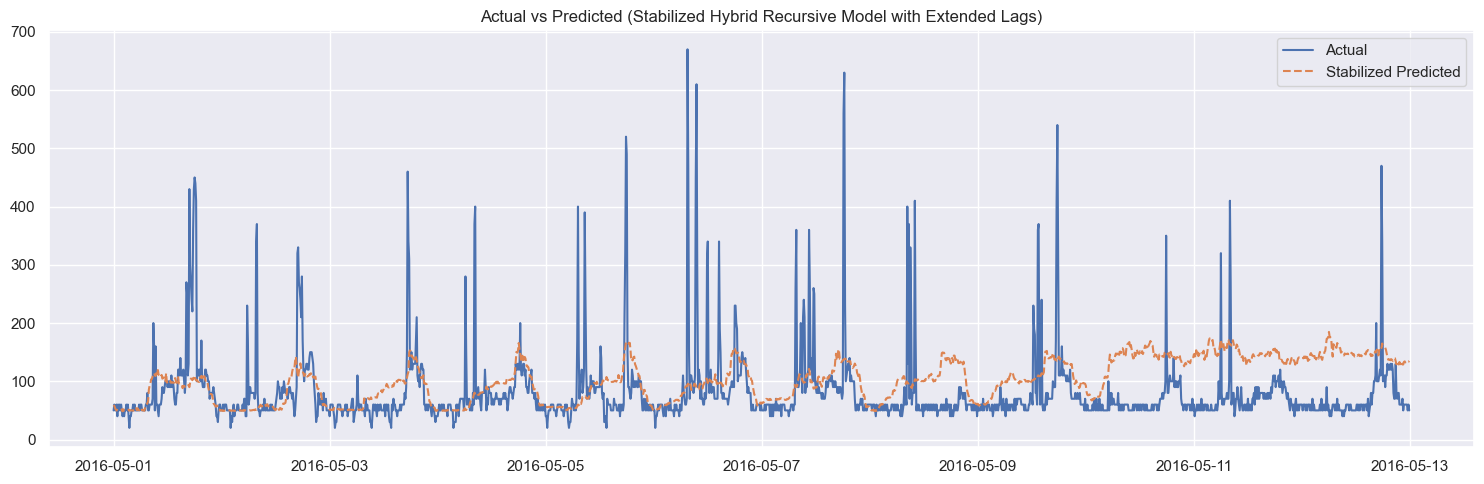

In [58]:
import numpy as np

# Initialize history buffer
history = y_trainval.tolist()
# Define a reasonable maximum value for predictions
max_pred_value = y_trainval.max() # Cap predictions at the max value seen in training
preds_stabilized = []

X_test_loop = X_test.copy()

for i in range(len(X_test_loop)):
    # Get current feature row
    current_features = X_test_loop.iloc[i:i+1].copy()

    # Update Appliance lag/rolling features from history
    for lag in lag_steps:
        current_features[f'Appliances_lag_{lag}'] = history[-lag]
    for window in rolling_windows:
        current_features[f'Appliances_roll_mean_{window}'] = np.mean(history[-window:])

    # Predict using the ensemble
    prob_peak = clf.predict_proba(current_features)[:, 1][0]
    threshold = 0.5

    if prob_peak > threshold:
        pred = reg_peak.predict(current_features)[0]
    else:
        pred = reg_nonpeak.predict(current_features)[0]

    # STABILITY CONTROL
    pred = min(pred, max_pred_value)
    pred = max(0, pred)

    # Append prediction and update history
    preds_stabilized.append(pred)
    history.append(pred)

# --- Evaluate and Plot ---
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

preds_stabilized_series = pd.Series(preds_stabilized, index=y_test.index)

mae = mean_absolute_error(y_test, preds_stabilized_series)
rmse = mean_squared_error(y_test, preds_stabilized_series, squared=False)
r2 = r2_score(y_test, preds_stabilized_series)

print("\n📌 Stabilized Hybrid Recursive Model (Extended Lags)")
print(f"Test MAE : {mae:.2f}")
print(f"Test RMSE: {rmse:.2f}")
print(f"Test R²  : {r2:.3f}")

plt.figure(figsize=(15, 5))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, preds_stabilized_series, label='Stabilized Predicted', linestyle='--')
plt.title("Actual vs Predicted (Stabilized Hybrid Recursive Model with Extended Lags)")
plt.legend()
plt.tight_layout()
plt.show()

***Conclusion:*** Explanatory variable only Ensemble model with quantile peak regressor - seems to be the most effective model for this task.

## Step 6: Holdout Set Prediction

Production Pipeline:
- The final model pipeline loads the trained ensemble components and feature list.
- Applies consistent feature engineering to the holdout set.
- Makes predictions using the ensemble, ensuring all features and logic match the training phase.
- Outputs predictions for the holdout period

In [59]:
import pandas as pd
import numpy as np
import joblib

# --- Load models and feature list ---
clf = joblib.load('peak_classifier.joblib')
reg_nonpeak = joblib.load('regressor_nonpeak.joblib')
reg_peak = joblib.load('regressor_peak.joblib')
feature_list = joblib.load('ensemble_feature_list.joblib')

# --- Load and prepare data ---
df1 = pd.read_csv('./dataset_1.csv', parse_dates=['date'], index_col='date')
df2 = pd.read_csv('./dataset_2.csv', parse_dates=['date'], index_col='date')

# Combine for rolling features continuity
df2['Appliances'] = 0  # Dummy column for compatibility
full_df = pd.concat([df1, df2])
full_df_interp = full_df.interpolate(limit=6, limit_direction='forward')

# --- Feature engineering (must match training exactly) ---
def create_features(df):
    df_fe = df.copy()
    # Time-based features
    df_fe['hour'] = df_fe.index.hour
    df_fe['dayofweek'] = df_fe.index.dayofweek
    df_fe['is_weekend'] = (df_fe['dayofweek'] >= 5).astype(int)
    # Rolling stats for external variables
    external_cols = [
        'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'RH_4', 'T5', 'RH_5',
        'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9', 'T_out',
        'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility', 'Tdewpoint'
    ]
    for col in external_cols:
        for window in [6, 18]:
            df_fe[f'{col}_roll_mean_{window}'] = df_fe[col].rolling(window).mean()
            df_fe[f'{col}_roll_max_{window}'] = df_fe[col].rolling(window).max()
            df_fe[f'{col}_roll_min_{window}'] = df_fe[col].rolling(window).min()
            df_fe[f'{col}_roll_std_{window}'] = df_fe[col].rolling(window).std()
    # Interaction features (if used in training)
    for col in ['T_out', 'RH_out', 'Windspeed']:
        df_fe[f'{col}_x_hour'] = df_fe[col] * df_fe['hour']
        df_fe[f'{col}_x_weekend'] = df_fe[col] * df_fe['is_weekend']
    # Fill NaNs (from rolling at the start) with backfill
    df_fe = df_fe.bfill()
    return df_fe

full_df_fe = create_features(full_df_interp)

# --- Extract holdout features and align columns ---
X_holdout = full_df_fe.loc[df2.index]
# Add any missing columns as zeros, drop extras
for col in feature_list:
    if col not in X_holdout.columns:
        X_holdout[col] = 0
X_holdout = X_holdout[feature_list]

# --- Make predictions ---
probs_holdout = clf.predict_proba(X_holdout)[:, 1]
preds_holdout = []
for i in range(len(X_holdout)):
    x = X_holdout.iloc[i].values.reshape(1, -1)
    prob_peak = probs_holdout[i]
    pred_peak = reg_peak.predict(x)[0]
    pred_nonpeak = reg_nonpeak.predict(x)[0]
    pred = prob_peak * pred_peak + (1 - prob_peak) * pred_nonpeak
    preds_holdout.append(pred)

# --- Save predictions ---
submission = pd.DataFrame({
    'date': X_holdout.index,
    'Appliances': np.clip(preds_holdout, 0, None)  # Ensure non-negative
})
submission.to_csv('predictions.csv', index=False)
print("Predictions saved to predictions.csv")
print(submission.head())

Predictions saved to predictions.csv
                 date  Appliances
0 2016-05-13 00:00:00      59.335
1 2016-05-13 00:10:00      68.513
2 2016-05-13 00:20:00      61.444
3 2016-05-13 00:30:00      61.491
4 2016-05-13 00:40:00      64.571


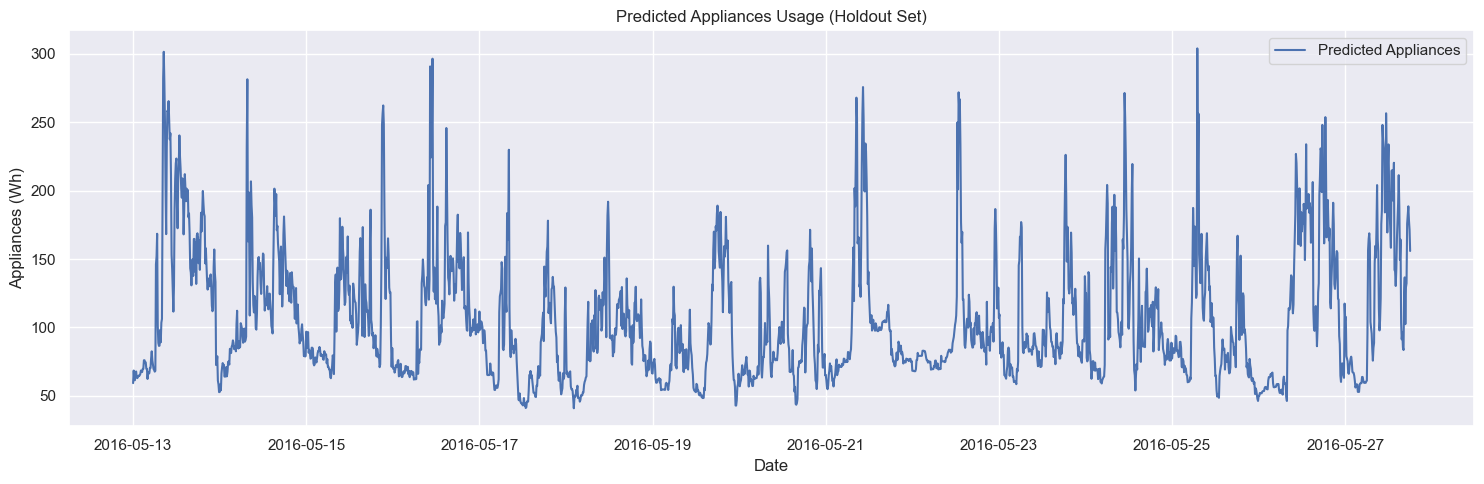

In [60]:
import pandas as pd
import matplotlib.pyplot as plt

# Load predictions
preds = pd.read_csv('predictions.csv', parse_dates=['date'])

plt.figure(figsize=(15, 5))
plt.plot(preds['date'], preds['Appliances'], label='Predicted Appliances', color='b')
plt.title('Predicted Appliances Usage (Holdout Set)')
plt.xlabel('Date')
plt.ylabel('Appliances (Wh)')
plt.legend()
plt.tight_layout()
plt.show()

## Key Takeaways
- Recursive evaluation is critical for honest assessment of time series models using lagged targets.
- Ensemble approaches (with peak-aware logic) can improve both accuracy and robustness.
- Consistent feature engineering and careful handling of missing data are essential for reliable deployment.

## Limitations

While the final ensemble model using only explanatory variables performed well in capturing overall usage trends and weekly seasonality, it consistently underpredicted sharp peaks in appliance energy consumption (As was seen in the final model's actual vs prediction graph). This is particularly evident in high-demand periods where actual usage exceeded 500–700 Wh, but the model predictions remained significantly lower. Capturing extreme values more accurately remains a key opportunity for future refinement.

### Addressing Peak Handling: What Was Tried and What Remains

- **Lagged Target Variables:**  
  I incorporated lagged values of the target (previous appliance usage) as features, both in short-lag and full-lag models, to help the model respond to sudden demand shifts.  
  *Result:* This improved general accuracy but did not fully resolve underprediction of rare peaks, especially in recursive forecasting.

- **Rolling Statistical Features:**  
  I engineered rolling means, max, min, and standard deviation features for both the target and key predictors to help the model detect volatility and anticipate spikes.  
  *Result:* These features provided some benefit, but peak events remained difficult to predict accurately.

- **Peak Classifier & Hybrid/Ensemble Modeling:**  
  I implemented a two-stage ensemble: a classifier to flag potential peaks, and separate regressors for peak and non-peak periods (including quantile regression and oversampling for peaks).  
  *Result:* This approach improved peak detection and prediction somewhat, but high-usage events are still not captured as robustly as desired.

- **What Was Not Fully Explored:**  
  While I considered post-prediction adjustment rules (e.g., boosting predictions when a spike is likely), I did not implement these due to concerns about robustness and the risk of introducing new errors without strong triggers.

#### **Conclusion**
Despite systematically trying lagged targets, rolling stats, and hybrid/ensemble models, robust peak handling remains a challenge. Further improvements may require:
- More sophisticated post-prediction adjustment,
- Alternative architectures (e.g., sequence models) - I have experimented with TimesFM and LSTM on GPU but did not show drastic improvement over LightGBM.
- Or additional external data/features.


____
### Risks, and Business Applications

#### Risks of Applying Machine Learning to Time Series Data
- **Temporal Leakage:** If future information is inadvertently used in training (e.g., using future lags or rolling statistics), it will cause data leakage and lead to overly optimistic results that won’t generalize in production.
- **Error Accumulation:** Recursive forecasting (feeding predictions back as inputs) can cause errors to compound, especially if the model is autoregressive.
- **Overfitting:** Machine learning models may fit noise or spurious correlations, especially with many features or limited data.

#### Business Applications of Household Electricity Usage Prediction
- **Demand Response & Grid Optimization:** Utilities can better balance supply and demand, reducing the need for expensive peaking power plants and minimizing blackouts.
- **Investment Risk Assessment:** Financial institutions and climate funds can assess the energy efficiency and volatility of residential demand, aiding in the evaluation of green mortgage products, energy-efficiency retrofits, and sustainable housing investments.
- **Renewable Energy Integration:** Renewable energy providers can use predictions to align generation (e.g., solar, wind) with household demand patterns, improving grid stability and storage planning.
- **Dynamic Pricing:** Enables time-of-use tariffs, where electricity prices vary based on predicted demand, encouraging off-peak usage.
- **Personalized Energy Report:** Households can receive tailored recommendations to shift or reduce usage, saving money and reducing environmental impact.
- **Fault Detection:** Sudden changes in predicted vs. actual usage can flag faulty appliances or energy leaks.
- **Integration with Smart Devices:** Predictions can automate smart thermostats, EV charging, or battery storage to optimize for cost and sustainability.
- **Policy & Planning:** City planners and policymakers can use aggregate predictions to inform infrastructure investments and sustainability initiatives. 

